### Comprehensive Retail Analysis: Cohort, RFM, and Sales Forecasting with FB Prophet

This data set is sourced from UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/352/online+retail

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. The variables included in the data set are as below:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides. 

### 0. LOADING LIBRARIES:

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import inflection
import warnings
from itertools import combinations
from datetime import datetime
import datetime as dt

from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet

from sklearn.metrics import r2_score, mean_squared_error

### 1. UNDERSTANDING THE DATASET:

In [8]:
df = pd.read_excel(r"C:\Users\Maisam\Downloads\Customer Lifetime Value - BG-NGB Modelling\online_retail_dataset.xlsx")

In [9]:
df.columns = [inflection.underscore(col) for col in df.columns]

In [10]:
df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

         invoice_date  unit_price  customer_id         country  
0 2010-12-01 08:26:00        2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00        3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00        2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00        3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00        3.39      17850.0  United Kingdom

In [11]:
df.shape

(541909, 8)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [13]:
df.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [14]:
df[df.description.isnull()]

invoice_no stock_code description  quantity        invoice_date  \
622        536414      22139         NaN        56 2010-12-01 11:52:00   
1970       536545      21134         NaN         1 2010-12-01 14:32:00   
1971       536546      22145         NaN         1 2010-12-01 14:33:00   
1972       536547      37509         NaN         1 2010-12-01 14:33:00   
1987       536549     85226A         NaN         1 2010-12-01 14:34:00   
...           ...        ...         ...       ...                 ...   
535322     581199      84581         NaN        -2 2011-12-07 18:26:00   
535326     581203      23406         NaN        15 2011-12-07 18:31:00   
535332     581209      21620         NaN         6 2011-12-07 18:35:00   
536981     581234      72817         NaN        27 2011-12-08 10:33:00   
538554     581408      85175         NaN        20 2011-12-08 14:06:00   

        unit_price  customer_id         country  
622            0.0          NaN  United Kingdom  
1970           0.0          NaN  United Kingdom  
1971           0.0          NaN  United Kingdom  
1972           0.0          NaN  United Kingdom  
1987           0.0          NaN  United Kingdom  
...            ...          ...             ...  
535322         0.0          NaN  United Kingdom  
535326         0.0          NaN  United Kingdom  
535332         0.0          NaN  United Kingdom  
536981         0.0          NaN  United Kingdom  
538554         0.0          NaN  United Kingdom  

[1454 rows x 8 columns]

For instances where description is null, we can observe that unit_price and customer_id are also null.


In [16]:
df[df.description.isnull()].customer_id.nunique()

0

In [17]:
df[df.description.isnull()].unit_price.value_counts()

unit_price
0.0    1454
Name: count, dtype: int64

Since there are no values associated with customer_id, and unit_price, we will drop these values as these wouldn't add much to our analysis

In [19]:
df = df[df.description.notnull()]

#### 1.1 Customer ID

In [21]:
df[df.customer_id.isnull()]

invoice_no stock_code                      description  quantity  \
1443       536544      21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444       536544      21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445       536544      21786               POLKADOT RAIN HAT          4   
1446       536544      21787            RAIN PONCHO RETROSPOT         2   
1447       536544      21790               VINTAGE SNAP CARDS         9   
...           ...        ...                              ...       ...   
541536     581498     85099B          JUMBO BAG RED RETROSPOT         5   
541537     581498     85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538     581498      85150    LADIES & GENTLEMEN METAL SIGN         1   
541539     581498      85174                S/4 CACTI CANDLES         1   
541540     581498        DOT                   DOTCOM POSTAGE         1   

              invoice_date  unit_price  customer_id         country  
1443   2010-12-01 14:32:00        2.51          NaN  United Kingdom  
1444   2010-12-01 14:32:00        2.51          NaN  United Kingdom  
1445   2010-12-01 14:32:00        0.85          NaN  United Kingdom  
1446   2010-12-01 14:32:00        1.66          NaN  United Kingdom  
1447   2010-12-01 14:32:00        1.66          NaN  United Kingdom  
...                    ...         ...          ...             ...  
541536 2011-12-09 10:26:00        4.13          NaN  United Kingdom  
541537 2011-12-09 10:26:00        4.13          NaN  United Kingdom  
541538 2011-12-09 10:26:00        4.96          NaN  United Kingdom  
541539 2011-12-09 10:26:00       10.79          NaN  United Kingdom  
541540 2011-12-09 10:26:00     1714.17          NaN  United Kingdom  

[133626 rows x 8 columns]

From initial look, we can observe that stock_code has some alpha-numeric values where it should have been a 5 digit number only. Hints towards exploring stock_code in more detail.

In [23]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.customer_id.notnull()]

print("We have {} observations after removing unknown customers.".format(df.shape[0]))

We have 540455 observations.
We have 406829 observations after removing unknown customers.


In [24]:
df.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

Although nulls have been removed, let's dive a bit further to remove odd denominations such as "NAN", "na" or "Unknown". 

In [26]:
df[df.description.str.len() < 5]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

#### 1.2 Invoice No:

In [28]:
df.invoice_no.value_counts().tail(10)

invoice_no
562424     1
570265     1
C554154    1
C562425    1
545347     1
554155     1
570248     1
545414     1
545418     1
565192     1
Name: count, dtype: int64

Invoice No is supposed to be a 6 digit coded number, invoice_no starting with "C" are cancellations.

In [30]:
df[df["invoice_no"].str.startswith("C", na=False)]

invoice_no stock_code                       description  quantity  \
141       C536379          D                          Discount        -1   
154       C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235       C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236       C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237       C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...           ...        ...                               ...       ...   
540449    C581490      23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541    C581499          M                            Manual        -1   
541715    C581568      21258        VICTORIAN SEWING BOX LARGE        -5   
541716    C581569      84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717    C581569      20979     36 PENCILS TUBE RED RETROSPOT        -5   

              invoice_date  unit_price  customer_id         country  
141    2010-12-01 09:41:00       27.50      14527.0  United Kingdom  
154    2010-12-01 09:49:00        4.65      15311.0  United Kingdom  
235    2010-12-01 10:24:00        1.65      17548.0  United Kingdom  
236    2010-12-01 10:24:00        0.29      17548.0  United Kingdom  
237    2010-12-01 10:24:00        0.29      17548.0  United Kingdom  
...                    ...         ...          ...             ...  
540449 2011-12-09 09:57:00        0.83      14397.0  United Kingdom  
541541 2011-12-09 10:28:00      224.69      15498.0  United Kingdom  
541715 2011-12-09 11:57:00       10.95      15311.0  United Kingdom  
541716 2011-12-09 11:58:00        1.25      17315.0  United Kingdom  
541717 2011-12-09 11:58:00        1.25      17315.0  United Kingdom  

[8905 rows x 8 columns]

In [31]:
df['invoice_no'] = df['invoice_no'].astype(str)

In [32]:
df['cancellation'] = df['invoice_no'].apply(lambda x: 1 if x.startswith('C') else 0)

In [33]:
df = df[df['cancellation'] != 1].copy()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    397924 non-null  object        
 1   stock_code    397924 non-null  object        
 2   description   397924 non-null  object        
 3   quantity      397924 non-null  int64         
 4   invoice_date  397924 non-null  datetime64[ns]
 5   unit_price    397924 non-null  float64       
 6   customer_id   397924 non-null  float64       
 7   country       397924 non-null  object        
 8   cancellation  397924 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB


All invoices that were wrongly coded or were cancellations have been dropped.

#### 1.3 Stock Codes:

In [37]:
df['stock_code'] = df['stock_code'].astype(str)
df[df.stock_code.str.contains("^[a-zA-Z]")].stock_code.value_counts()

stock_code
POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

In [38]:
df[df.stock_code.str.len() > 5].stock_code.value_counts()

stock_code
85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35610C       1
90187B       1
90190A       1
90190B       1
90214Z       1
Name: count, Length: 875, dtype: int64

Stock code is supposed to be a 5 digit number, although we can observe that some stock codes are non-customer related such as POST, BANK CHARGES etc. Similarly, some stock codes are ending with a specific alphabet. Since we aren't sure what these are, we will keep these for now.

In [40]:
df =  df[~ df.stock_code.str.contains("^[a-zA-Z]")]

In [41]:
df["description"] = df["description"].str.lower()

In [42]:
df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

         invoice_date  unit_price  customer_id         country  cancellation  
0 2010-12-01 08:26:00        2.55      17850.0  United Kingdom             0  
1 2010-12-01 08:26:00        3.39      17850.0  United Kingdom             0  
2 2010-12-01 08:26:00        2.75      17850.0  United Kingdom             0  
3 2010-12-01 08:26:00        3.39      17850.0  United Kingdom             0  
4 2010-12-01 08:26:00        3.39      17850.0  United Kingdom             0

In [43]:
df.groupby("stock_code")["description"].nunique()[df.groupby("stock_code")["description"].nunique() != 1]

stock_code
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: description, Length: 213, dtype: int64

We can observe that 213 codes have multiple descriptions.

In [45]:
df[df.stock_code == "16156L"].description.value_counts()

description
wrap carousel     14
wrap, carousel     4
Name: count, dtype: int64

In [46]:
df[df.stock_code == "17107D"].description.value_counts()

description
flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: count, dtype: int64

In [47]:
df[df.stock_code == "90014C"].description.value_counts()

description
silver/black orbit necklace        2
silver and black orbit necklace    1
Name: count, dtype: int64

From a broader look, the descriptions have minor semantic differences of "," , "/", "." etc.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396370 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    396370 non-null  object        
 1   stock_code    396370 non-null  object        
 2   description   396370 non-null  object        
 3   quantity      396370 non-null  int64         
 4   invoice_date  396370 non-null  datetime64[ns]
 5   unit_price    396370 non-null  float64       
 6   customer_id   396370 non-null  float64       
 7   country       396370 non-null  object        
 8   cancellation  396370 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.2+ MB


#### 1.4 Customer ID:

In [51]:
df['customer_id'] = df['customer_id'].astype(int)

C:\Users\Maisam\AppData\Local\Temp\ipykernel_18296\476623329.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h",


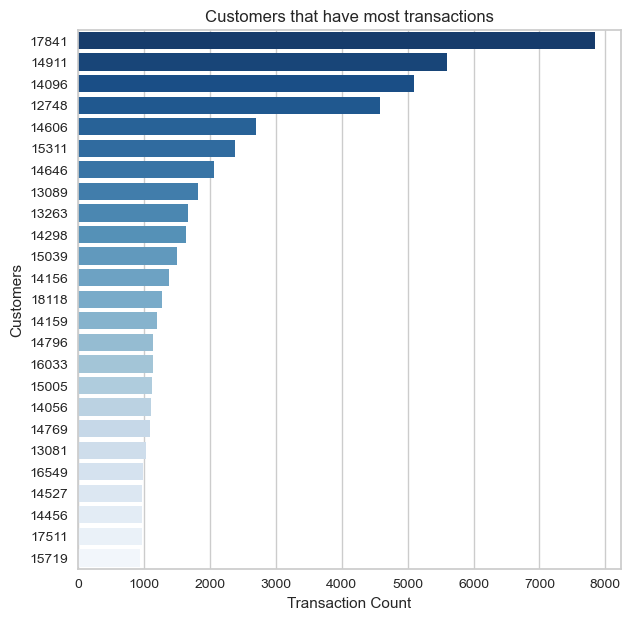

In [52]:
customer_counts = df.customer_id.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (7, 7))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Blues_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

#### 1.5 Country:

In [54]:
df.country.value_counts()

country
United Kingdom          354005
Germany                   8659
France                    8034
EIRE                      7138
Spain                     2423
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1425
Australia                 1184
Norway                    1049
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45


C:\Users\Maisam\AppData\Local\Temp\ipykernel_18296\3880389695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h",


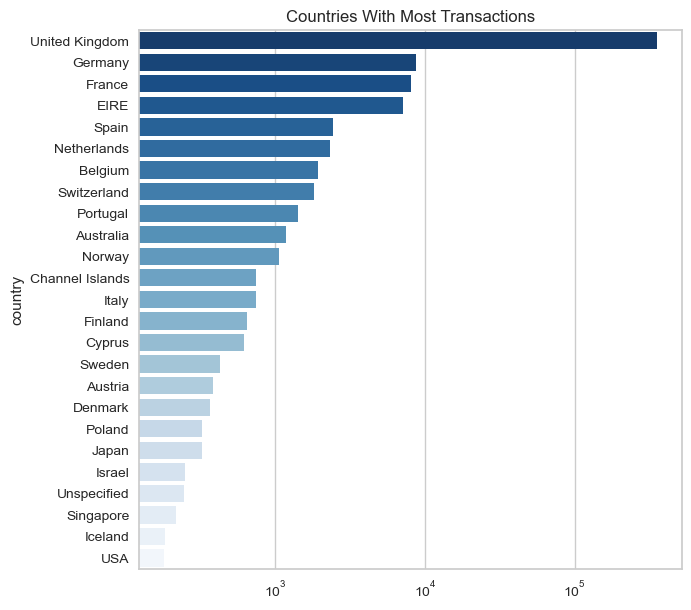

In [55]:
country_counts = df.country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (7, 7))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")

plt.title("Countries With Most Transactions")
plt.xscale("log")
plt.show()

#### 1.6 Unit Price:

In [57]:
df["unit_price"].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: unit_price, dtype: float64

We can observe a unit price of 0 aswell. Let's investigate this.

In [59]:
df[df.unit_price == 0].head()

invoice_no stock_code                   description  quantity  \
9302      537197      22841  round cake tin vintage green         1   
33576     539263      22580  advent calendar gingham sack         4   
40089     539722      22423      regency cakestand 3 tier        10   
47068     540372      22090       paper bunting retrospot        24   
47070     540372      22553        plasters in tin skulls        24   

             invoice_date  unit_price  customer_id         country  \
9302  2010-12-05 14:02:00         0.0        12647         Germany   
33576 2010-12-16 14:36:00         0.0        16560  United Kingdom   
40089 2010-12-21 13:45:00         0.0        14911            EIRE   
47068 2011-01-06 16:41:00         0.0        13081  United Kingdom   
47070 2011-01-06 16:41:00         0.0        13081  United Kingdom   

       cancellation  
9302              0  
33576             0  
40089             0  
47068             0  
47070             0

Since, we can't see any observable patterns, we will remove these instances.

In [61]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.unit_price > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 396370 observations.
We have 396337 observations after removing records that have 0 unit price.


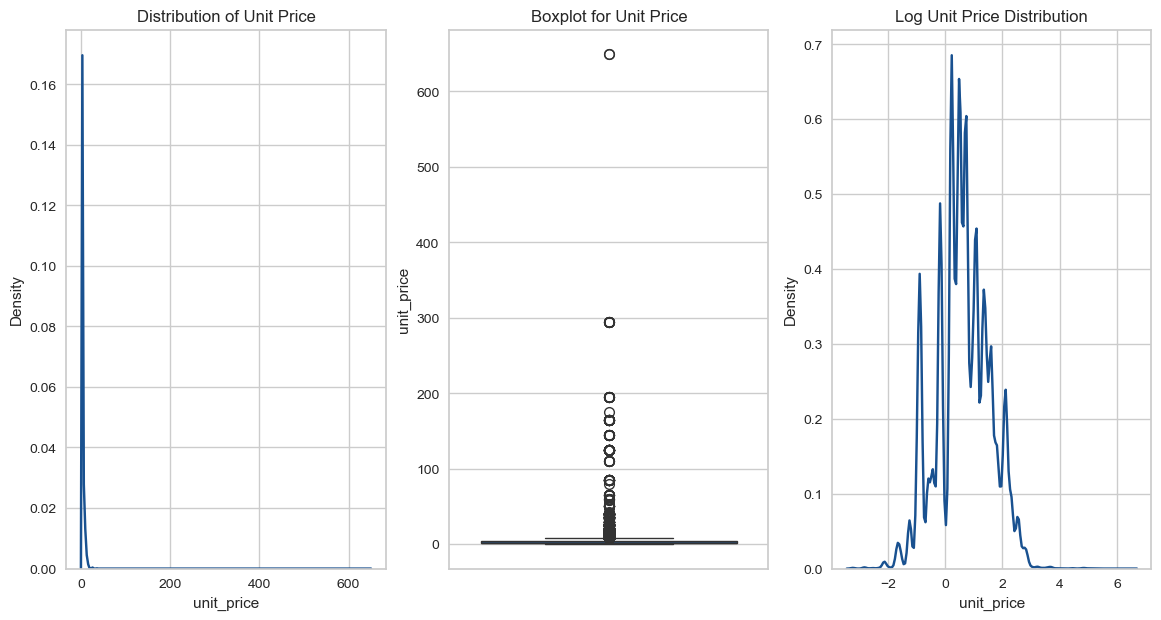

In [62]:
fig, axes = plt.subplots(1, 3, figsize = (14, 7))

sns.kdeplot(df["unit_price"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["unit_price"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["unit_price"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [63]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


In [64]:
np.quantile(df.unit_price, 0.99)

12.75

In [65]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.unit_price > 0.1) & (df.unit_price < 20)]

print("We have {} observations after removing unit prices smaller than 0.1 and greater than 20.".format(df.shape[0]))

We have 396337 observations.
We have 395385 observations after removing unit prices smaller than 0.1 and greater than 20.


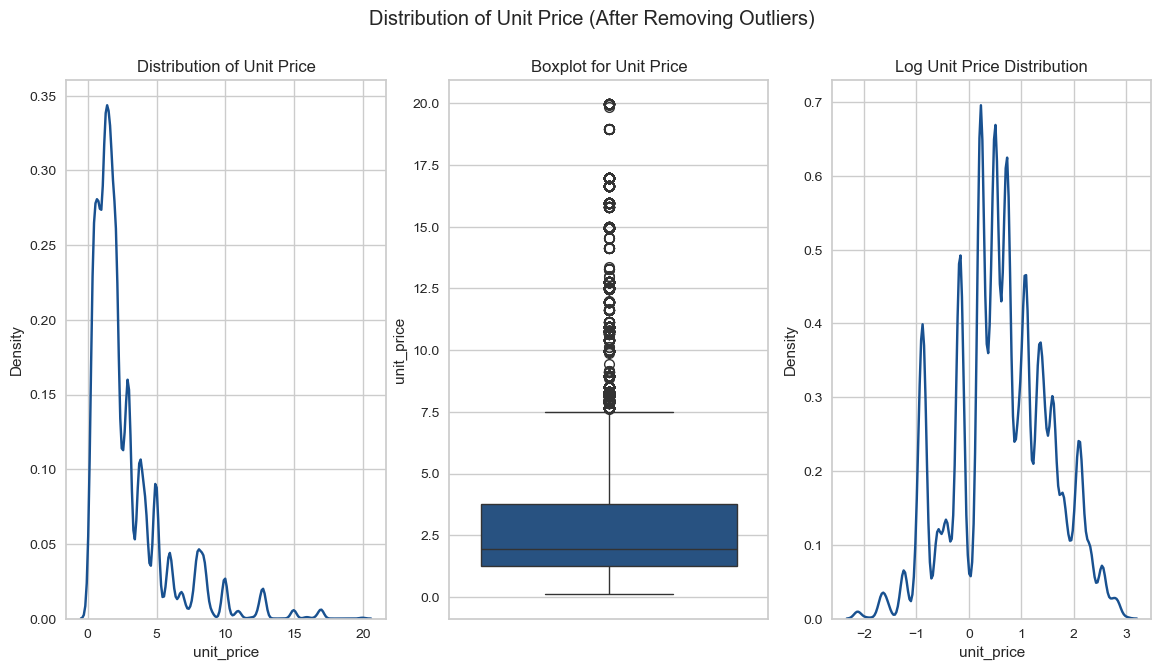

In [66]:
fig, axes = plt.subplots(1, 3, figsize = (14, 7))

sns.kdeplot(df["unit_price"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["unit_price"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["unit_price"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

#### 1.7 Quantity:

In [68]:
df["quantity"].describe()

count    395385.000000
mean         12.946075
std         179.665683
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: quantity, dtype: float64

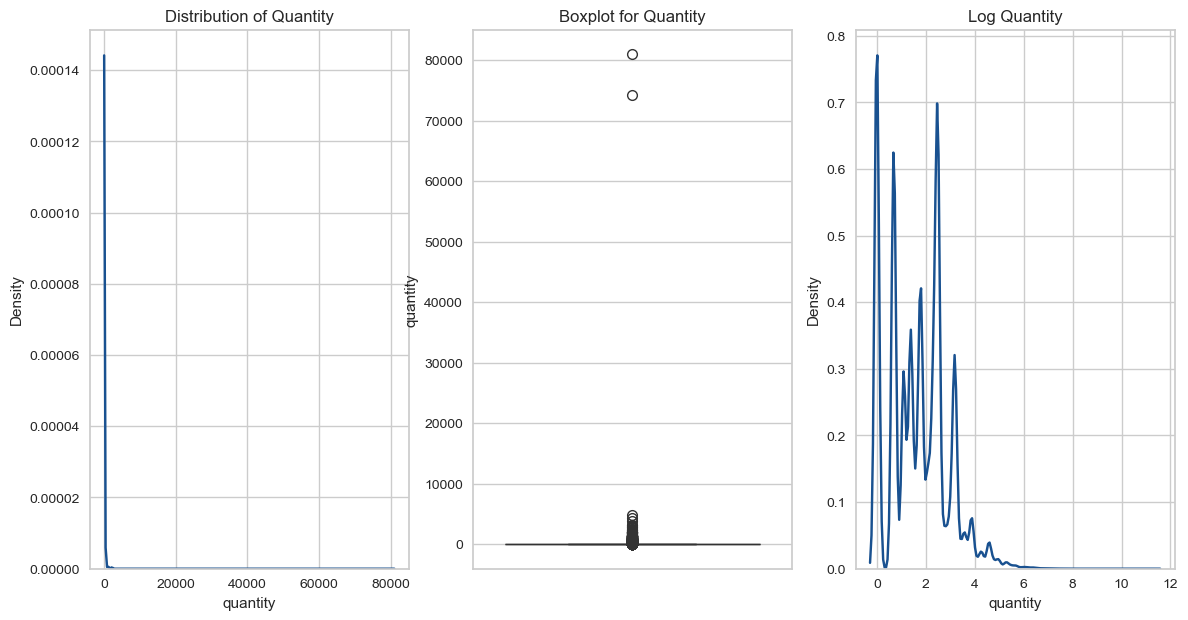

In [69]:
fig, axes = plt.subplots(1, 3, figsize = (14, 7))

sns.kdeplot(df["quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [70]:
print("Upper limit for Quantity: " + str(np.exp(5)))

Upper limit for Quantity: 148.4131591025766


In [71]:
np.quantile(df.quantity, 0.99)

120.0

In [72]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 395385 observations.
We have 392735 observations after removing quantities greater than 150.


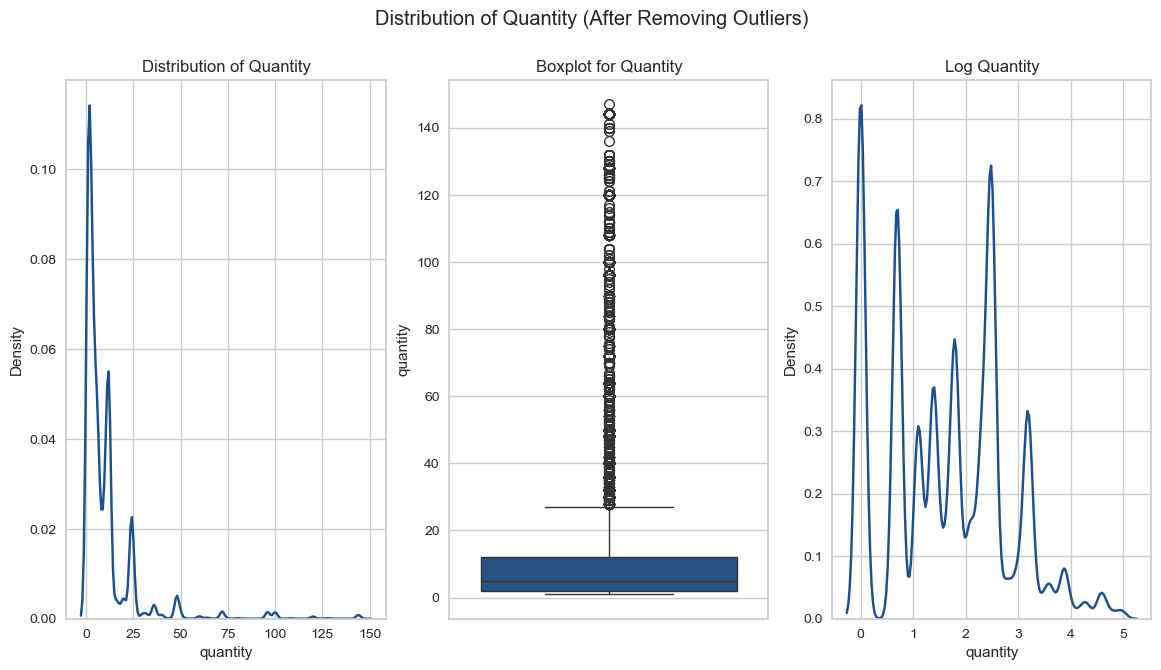

In [73]:
fig, axes = plt.subplots(1, 3, figsize = (14, 7))

sns.kdeplot(df["quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [74]:
df["total_price"] = df["quantity"] * df["unit_price"]
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [75]:
df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

         invoice_date  unit_price  customer_id         country  cancellation  \
0 2010-12-01 08:26:00        2.55        17850  United Kingdom             0   
1 2010-12-01 08:26:00        3.39        17850  United Kingdom             0   
2 2010-12-01 08:26:00        2.75        17850  United Kingdom             0   
3 2010-12-01 08:26:00        3.39        17850  United Kingdom             0   
4 2010-12-01 08:26:00        3.39        17850  United Kingdom             0   

   total_price  
0        15.30  
1        20.34  
2        22.00  
3        20.34  
4        20.34

In [76]:
df.drop("cancellation", axis = 1, inplace = True)
df.to_csv("online_retail_final.csv", index = False)

### 2. COHORT & RETENTION ANALYSIS:

A cohort simply means that a group of people they have same characteristics.

Generally, we have three type of cohort analysis:

- Time cohorts or Acquisition cohorts: Groups are divided by first activity.
- Behavior cohorts or Segment-Based cohorts: Groups are divided by their behaivors and actions about your service.
- Size cohorts: Size-based cohorts refer to the various sizes of customers who purchase a company’s products or services.

Cohort analysis is a better way of looking at data. Its application is not limited to a single industry or function. For example, eCommerce companies can use cohort analysis to spot products that have more potential for sales growth. In digital marketing, it can help identify web pages that perform well based on time spent on websites, conversions or sign-ups. In product marketing, this analysis can be used to identify the success of feature adoption rate and also to reduce churn rates.

In [80]:
print("Min date: {} \nMax date: {}".format(df.invoice_date.min(), df.invoice_date.max()))
print("Time difference is: {}".format(df.invoice_date.max() - df.invoice_date.min()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


Our dataset contains invoice records for more than one year. We will create monthly cohorts.

We will group customers for first invoice record. Cohort index will be number of months since first transaction.

In [82]:
def get_month(x): return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [83]:
df["invoice_month"] = df["invoice_date"].apply(get_month)

df["cohort_month"] = df.groupby("customer_id")["invoice_month"].transform("min")

In [84]:
df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

         invoice_date  unit_price  customer_id         country  total_price  \
0 2010-12-01 08:26:00        2.55        17850  United Kingdom        15.30   
1 2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34   
2 2010-12-01 08:26:00        2.75        17850  United Kingdom        22.00   
3 2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34   
4 2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34   

  invoice_month cohort_month  
0    2010-12-01   2010-12-01  
1    2010-12-01   2010-12-01  
2    2010-12-01   2010-12-01  
3    2010-12-01   2010-12-01  
4    2010-12-01   2010-12-01

In [85]:
invoice_year, invoice_month, invoice_day = get_dates(df, "invoice_month")
cohort_year, cohort_month, cohort_day = get_dates(df, "cohort_month")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["cohort_index"] = 12 * year_diff + month_diff + 1

In [86]:
cohort_data = df.groupby(["cohort_index", "cohort_month"])["customer_id"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index = "cohort_month", columns = "cohort_index", values = "customer_id")

cohort_pivot

cohort_index     1      2      3      4      5      6      7      8      9   \
cohort_month                                                                  
2010-12-01    874.0  319.0  280.0  329.0  317.0  350.0  316.0  303.0  304.0   
2011-01-01    409.0   91.0  112.0   94.0  131.0  119.0  103.0  100.0  123.0   
2011-02-01    375.0   68.0   69.0  103.0  100.0   90.0   94.0  100.0   92.0   
2011-03-01    450.0   66.0  111.0   90.0  101.0   75.0  119.0  104.0  124.0   
2011-04-01    297.0   64.0   61.0   61.0   56.0   68.0   65.0   77.0   22.0   
2011-05-01    280.0   55.0   48.0   49.0   59.0   65.0   75.0   26.0    NaN   
2011-06-01    240.0   42.0   38.0   64.0   54.0   78.0   23.0    NaN    NaN   
2011-07-01    189.0   34.0   39.0   42.0   50.0   21.0    NaN    NaN    NaN   
2011-08-01    170.0   32.0   41.0   41.0   22.0    NaN    NaN    NaN    NaN   
2011-09-01    297.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01    356.0   84.0   41.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01    322.0   36.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01     39.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cohort_index     10     11     12     13  
cohort_month                              
2010-12-01    345.0  327.0  440.0  231.0  
2011-01-01    135.0  151.0   48.0    NaN  
2011-02-01    115.0   25.0    NaN    NaN  
2011-03-01     38.0    NaN    NaN    NaN  
2011-04-01      NaN    NaN    NaN    NaN  
2011-05-01      NaN    NaN    NaN    NaN  
2011-06-01      NaN    NaN    NaN    NaN  
2011-07-01      NaN    NaN    NaN    NaN  
2011-08-01      NaN    NaN    NaN    NaN  
2011-09-01      NaN    NaN    NaN    NaN  
2011-10-01      NaN    NaN    NaN    NaN  
2011-11-01      NaN    NaN    NaN    NaN  
2011-12-01      NaN    NaN    NaN    NaN

From cohort table above, we can observe that we have 874 unique customer with their first transaction is in 2010-12. Its cohort month is 2010-12 and cohort index is 1. Go on the one right cell, it is 319. It means, 319 unique customers are retained for next month.

In [88]:
cohort_sizes = cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_sizes, axis = 0)
retention.index = retention.index.strftime("%Y-%m")

retention

cohort_index   1         2         3         4         5         6         7   \
cohort_month                                                                    
2010-12       1.0  0.364989  0.320366  0.376430  0.362700  0.400458  0.361556   
2011-01       1.0  0.222494  0.273839  0.229829  0.320293  0.290954  0.251834   
2011-02       1.0  0.181333  0.184000  0.274667  0.266667  0.240000  0.250667   
2011-03       1.0  0.146667  0.246667  0.200000  0.224444  0.166667  0.264444   
2011-04       1.0  0.215488  0.205387  0.205387  0.188552  0.228956  0.218855   
2011-05       1.0  0.196429  0.171429  0.175000  0.210714  0.232143  0.267857   
2011-06       1.0  0.175000  0.158333  0.266667  0.225000  0.325000  0.095833   
2011-07       1.0  0.179894  0.206349  0.222222  0.264550  0.111111       NaN   
2011-08       1.0  0.188235  0.241176  0.241176  0.129412       NaN       NaN   
2011-09       1.0  0.235690  0.303030  0.114478       NaN       NaN       NaN   
2011-10       1.0  0.235955  0.115169       NaN       NaN       NaN       NaN   
2011-11       1.0  0.111801       NaN       NaN       NaN       NaN       NaN   
2011-12       1.0       NaN       NaN       NaN       NaN       NaN       NaN   

cohort_index        8         9         10        11        12        13  
cohort_month                                                              
2010-12       0.346682  0.347826  0.394737  0.374142  0.503432  0.264302  
2011-01       0.244499  0.300733  0.330073  0.369193  0.117359       NaN  
2011-02       0.266667  0.245333  0.306667  0.066667       NaN       NaN  
2011-03       0.231111  0.275556  0.084444       NaN       NaN       NaN  
2011-04       0.259259  0.074074       NaN       NaN       NaN       NaN  
2011-05       0.092857       NaN       NaN       NaN       NaN       NaN  
2011-06            NaN       NaN       NaN       NaN       NaN       NaN  
2011-07            NaN       NaN       NaN       NaN       NaN       NaN  
2011-08            NaN       NaN       NaN       NaN       NaN       NaN  
2011-09            NaN       NaN       NaN       NaN       NaN       NaN  
2011-10            NaN       NaN       NaN       NaN       NaN       NaN  
2011-11            NaN       NaN       NaN       NaN       NaN       NaN  
2011-12            NaN       NaN       NaN       NaN       NaN       NaN

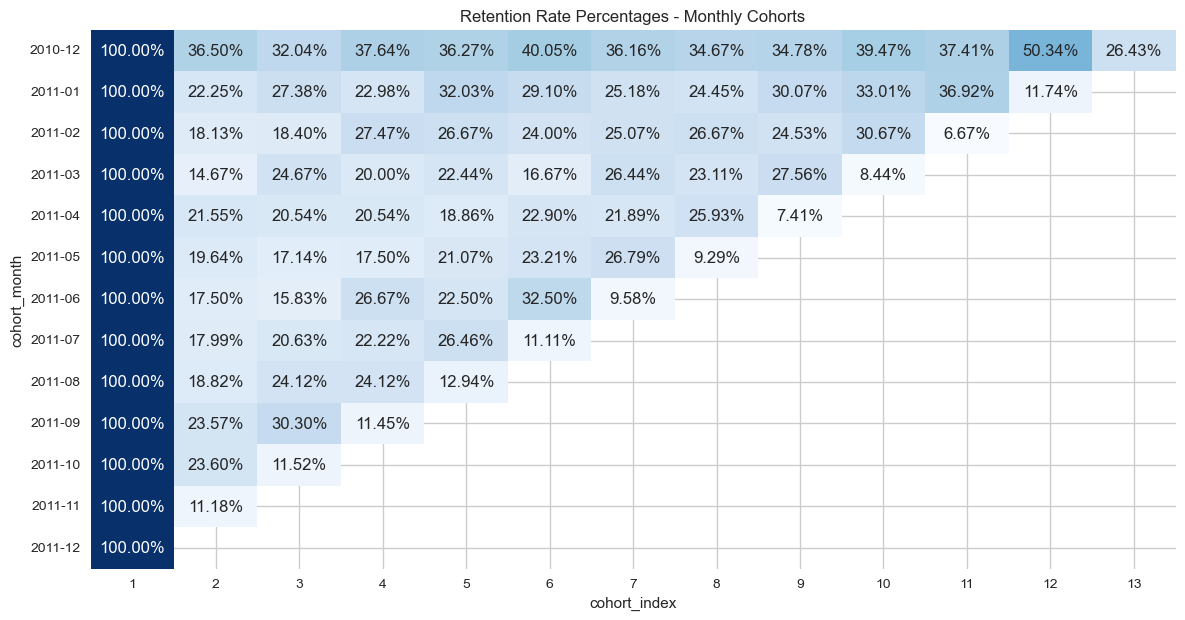

In [89]:
fig, ax = plt.subplots(figsize = (14, 7))

sns.heatmap(retention, cmap = "Blues", annot = True, fmt = ".2%", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

In [90]:
customer_per_month = df.groupby("cohort_month")["customer_id"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4298, 4259, 3937, 3581, 3284, 3114, 2925, 2685, 2405, 2108, 1658,
       1283,  874], dtype=int64)

In [91]:
customer_in_month = df.groupby("cohort_index")["customer_id"].nunique()
customer_in_month

cohort_index
1     4298
2      961
3      930
4      907
5      890
6      866
7      795
8      710
9      665
10     633
11     503
12     488
13     231
Name: customer_id, dtype: int64

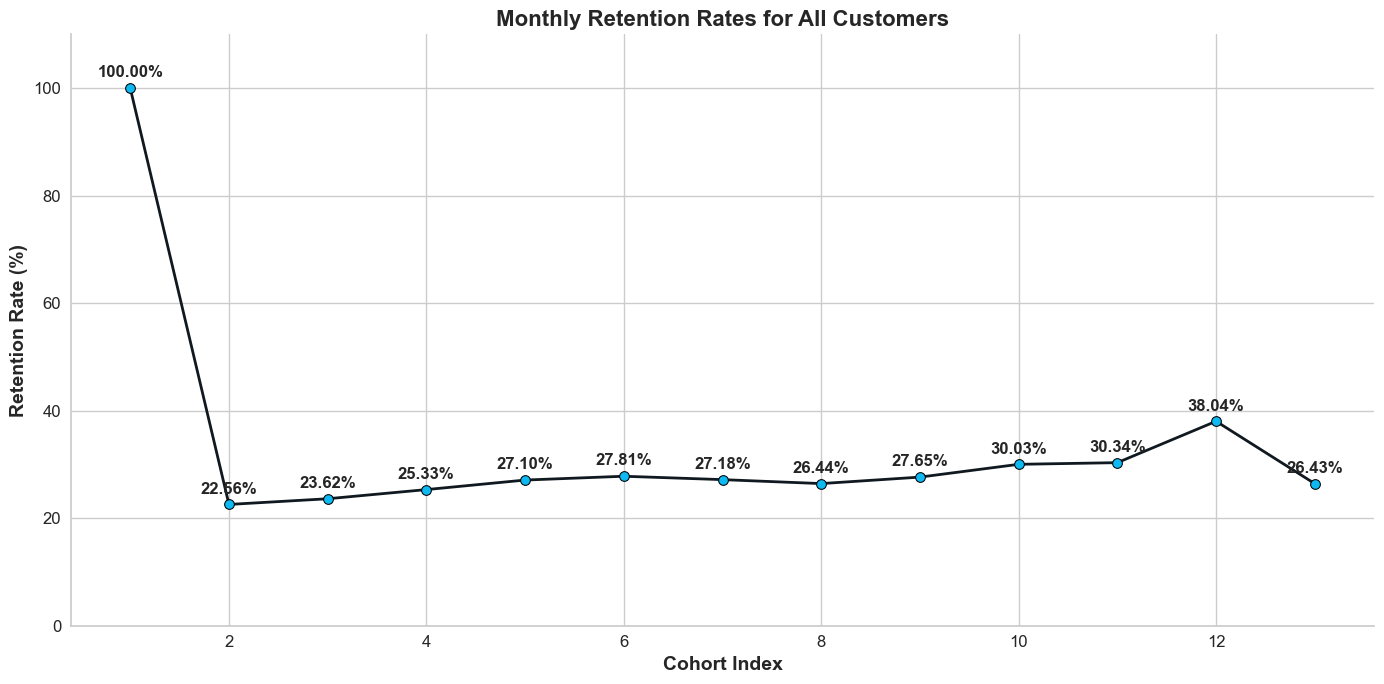

In [92]:
fig, ax = plt.subplots(figsize=(14, 7))

x = customer_in_month.index
y = 100 * (customer_in_month / customers)

sns.lineplot(x=x, y=y, color="#101820", marker="o", markerfacecolor="#0EB8F1", markeredgecolor="#000000", linewidth=2, ax=ax)

for x_val, y_val in zip(x, y):
    plt.text(x_val, y_val + 2, f"{y_val:.2f}%", ha='center', fontsize=12, weight ='bold')

plt.xlabel("Cohort Index", fontsize=14, weight='bold')
plt.ylabel("Retention Rate (%)", fontsize=14, weight='bold')
plt.title("Monthly Retention Rates for All Customers", fontsize=16, weight='bold')

sns.despine()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(0, max(y) + 10)

plt.tight_layout()
plt.show()

Retention rate increases marginally over the months with a sudden spike in 12th Months, most likely due to festive season.

In [94]:
monthly_customer_price_df = df.groupby("invoice_month").agg({"total_price": "sum","customer_id": "nunique"})
monthly_customer_price_df.head()

total_price  customer_id
invoice_month                          
2010-12-01       477001.27          874
2011-01-01       402460.88          728
2011-02-01       384935.12          746
2011-03-01       501435.63          959
2011-04-01       389147.37          843

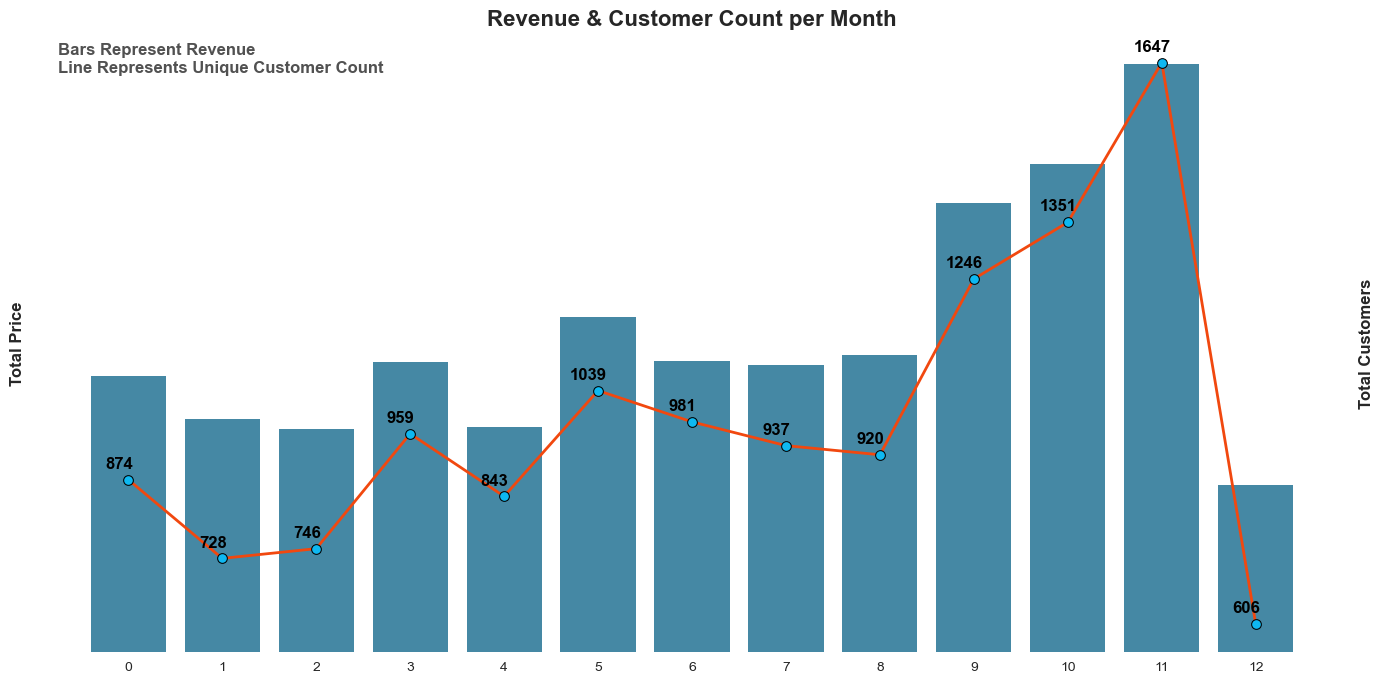

In [95]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(x=np.arange(len(monthly_customer_price_df.index)), y=monthly_customer_price_df.total_price, ax=ax, alpha=0.8)

ax2 = ax.twinx()
sns.lineplot(x=np.arange(len(monthly_customer_price_df.index)), y=monthly_customer_price_df.customer_id, ax=ax2,
             color="#F1480F", marker="o", markerfacecolor="#0EB8F1", markeredgecolor="#000000", linewidth=2)

ax.set_yticks([])
ax2.set_yticks([])

ax.set_ylabel("Total Price", fontsize=12, weight='bold')
ax2.set_ylabel("Total Customers", fontsize=12, weight='bold')

plt.title("Revenue & Customer Count per Month", fontsize=16, weight='bold')

ax.text(-0.75, 1000000, "Bars Represent Revenue \nLine Represents Unique Customer Count", 
        fontsize=12, alpha=0.8, weight='bold')

for x, y in zip(np.arange(len(monthly_customer_price_df.index)), monthly_customer_price_df.customer_id):
    ax2.text(x - 0.1, y + 20, str(int(y)), color="black", fontsize=12, weight='bold', ha='center')

sns.despine(left=True, right=True, bottom=True, top=True)
plt.tight_layout()

plt.show()

### 3. PARETO ANALYSIS:

The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”). Let's apply this principal on our dataset.

For our dataset, the two hypothesis that make sense according to this principal are:
- 80% of company's revenue comes from 20% of the customers.
- 80% of company's revenue comes from 20% of the products.

In [99]:
df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

         invoice_date  unit_price  customer_id         country  total_price  \
0 2010-12-01 08:26:00        2.55        17850  United Kingdom        15.30   
1 2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34   
2 2010-12-01 08:26:00        2.75        17850  United Kingdom        22.00   
3 2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34   
4 2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34   

  invoice_month cohort_month  cohort_index  
0    2010-12-01   2010-12-01             1  
1    2010-12-01   2010-12-01             1  
2    2010-12-01   2010-12-01             1  
3    2010-12-01   2010-12-01             1  
4    2010-12-01   2010-12-01             1

To test these hypothesis, we require two things:
- Individual sales records for customer/products.
- Cumulative sum.

Below, we have defined two functions as:
- pareto_data: finds individual revenue for customers/products and calculates cumulative percentage for each of these.
- pareto_plot: takes output from the function above and visualises it.

In [102]:
def pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)

    df_price["cumulative_percentage"] = (df_price[price].cumsum() / df_price[price].sum() * 100).round(2)
    
    return df_price

In [103]:
def pareto_plot(df, col, price, log = True):
    
    fig, ax = plt.subplots(figsize = (14, 5), dpi = 150)
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax)
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax)

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.cumulative_percentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.cumulative_percentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.cumulative_percentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue")
    ax2.set_ylabel("Cumulative Percentage")
    subject = "Customers" if col == "customer_id" else "Products"
    plt.title("Pareto Chart for " + subject)
    ax.set_xlabel(subject)
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

**Pareto Plot For Customers:**

In [105]:
customer_price = pareto_data(df, "customer_id", "total_price")

customer_price.head(10)

total_price  cumulative_percentage
customer_id                                    
14646          189796.00                   2.65
14911          129795.43                   4.46
12415           81455.09                   5.60
14156           81329.92                   6.73
18102           80619.70                   7.86
17511           78595.72                   8.95
15311           57178.46                   9.75
13089           56618.82                  10.54
14096           52147.65                  11.27
14088           49510.21                  11.96

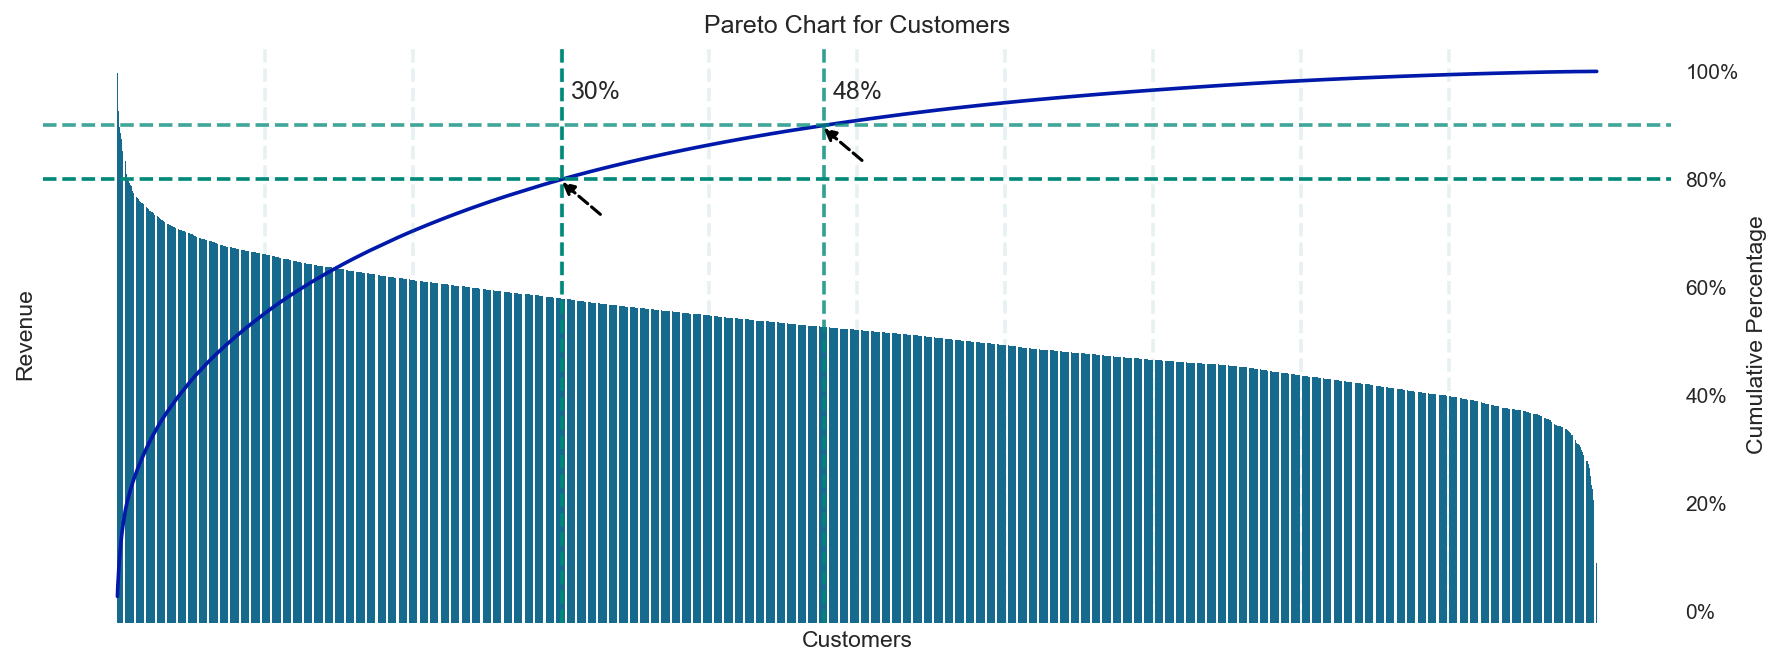

In [106]:
pareto_plot(customer_price, "customer_id", "total_price", log = True)

We can observe that 80% of company's revenue comes from top30 customers.

**Pareto Plot For Products:**

In [109]:
item_price = pareto_data(df, "stock_code", "total_price")
item_price.head(10)

total_price  cumulative_percentage
stock_code                                    
22423         132100.75                   1.84
85123A         68282.78                   2.80
47566          61166.83                   3.65
85099B         57382.08                   4.45
79321          37464.27                   4.97
84879          37428.74                   5.50
22086          35337.23                   5.99
23298          31210.55                   6.42
22960          30038.77                   6.84
23203          29890.08                   7.26

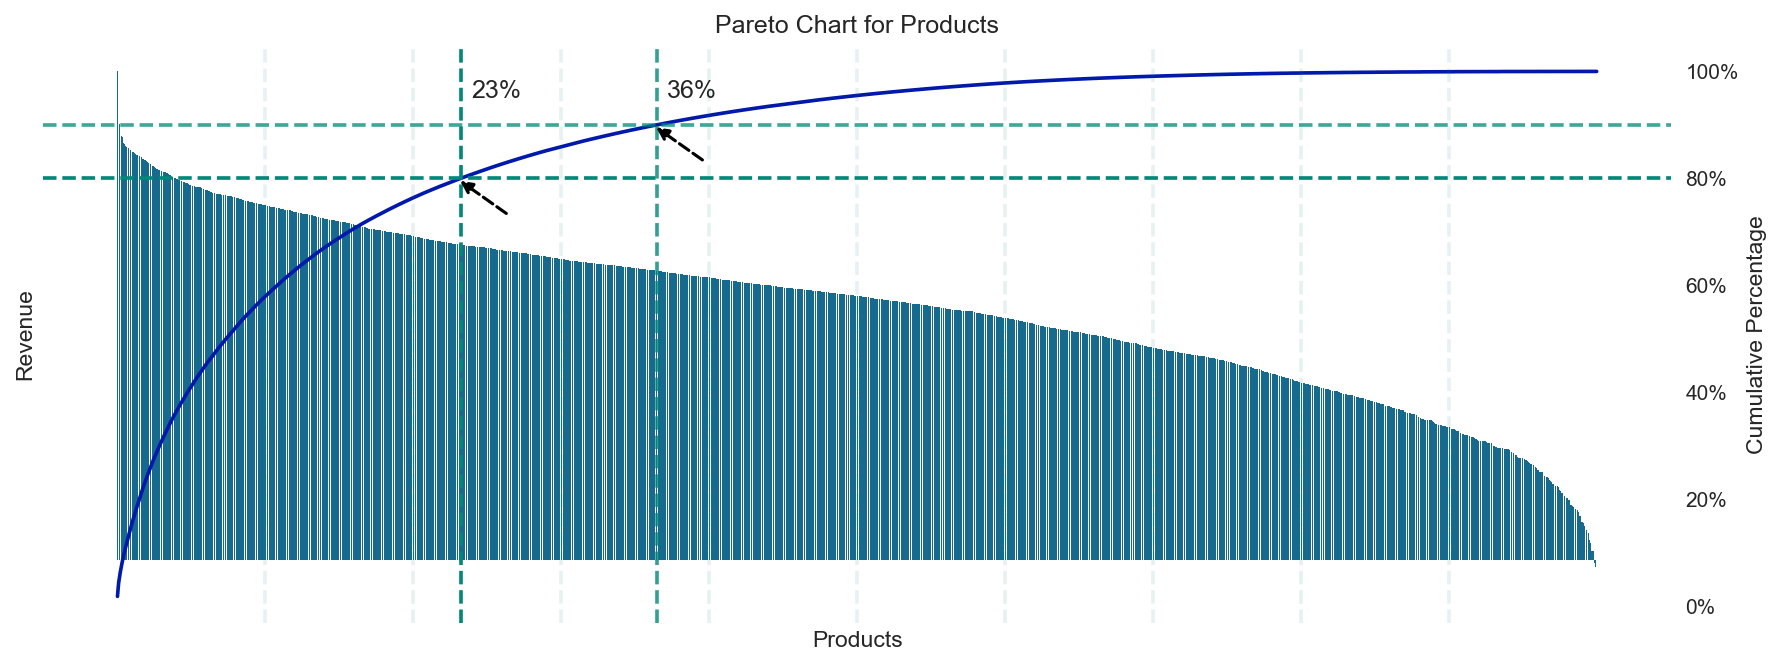

In [110]:
pareto_plot(item_price, "stock_code", "total_price", log = True)

We can observe that 80% of company's revenue comes from top23 products.

In [112]:
top_customers = customer_price[customer_price.cumulative_percentage <= 80].index.tolist()

products_for_top_customers = df[df.customer_id.isin(top_customers)].description.drop_duplicates().values.tolist()

products_for_other_customers = df[~df.customer_id.isin(top_customers)].description.drop_duplicates().values.tolist()

### 4. RFM Analysis:

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

- Recency: How recently a customer has made a purchase
- Frequency: How often a customer makes a purchase
- Monetary Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

In [115]:
print("Min date: {} \nMax date: {}".format(df.invoice_date.min(), df.invoice_date.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [116]:
last_day = df.invoice_date.max() + dt.timedelta(days = 1)
last_day

Timestamp('2011-12-10 12:50:00')

In [117]:
rfm_table = df.groupby("customer_id").agg({"invoice_date": lambda x: (last_day - x.max()).days,
                                         "invoice_no": "nunique",
                                         "total_price": "sum"})

rfm_table.rename(columns = {"invoice_date": "Recency",
                            "invoice_no": "Frequency",
                            "total_price": "Monetary"}, inplace = True)

rfm_table.head()

Recency  Frequency  Monetary
customer_id                              
12347              2          7   4060.40
12348             75          4   1437.24
12349             19          1   1417.60
12350            310          1    294.40
12352             36          7   1385.74

In [118]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

Recency  Frequency  Monetary  R  F  M
customer_id                                       
12347              2          7   4060.40  5  5  5
12348             75          4   1437.24  2  4  4
12349             19          1   1417.60  4  1  4
12350            310          1    294.40  1  1  2
12352             36          7   1385.74  3  5  4

In [119]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
customer_id                                                              
12347              2          7   4060.40  5  5  5         555         15
12348             75          4   1437.24  2  4  4         244         10
12349             19          1   1417.60  4  1  4         414          9
12350            310          1    294.40  1  1  2         112          4
12352             36          7   1385.74  3  5  4         354         12

RFM Segmentation can be done using the following:

- Champions:
Bought recently, buy often, and spend the most.

- Loyal Customers:
Buy on a regular basis, responsive to promotions.

- Potential Loyalists:
Recent customers with average frequency.

- Recent Customers:
Bought most recently, but not often.

- Promising:
Recent shoppers but haven’t spent much.

- Needs Attention:
Above-average recency, frequency, and monetary values. May not have bought very recently though.

- About to Sleep:
Below-average recency and frequency. Will lose them if not reactivated.

- At Risk:
It’s been some time since they’ve purchased. Need to bring them back!

- Can’t Lose Them:
Used to purchase frequently but haven’t returned for a long time.

- Hibernating:
Last purchase was a long time ago with a low number of orders. May be lost.des. May be lost.er of orders. May be lost.

*https://futurice.com/blog/know-your-customers-with-rfm

In [121]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
customer_id                                                                 
12347              2          7   4060.40  5  5  5         555         15   
12348             75          4   1437.24  2  4  4         244         10   
12349             19          1   1417.60  4  1  4         414          9   
12350            310          1    294.40  1  1  2         112          4   
12352             36          7   1385.74  3  5  4         354         12   

                     Segment  
customer_id                   
12347              Champions  
12348                At-Risk  
12349              Promising  
12350            Hibernating  
12352        Loyal Customers

Source for Segmentation Map: https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [123]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

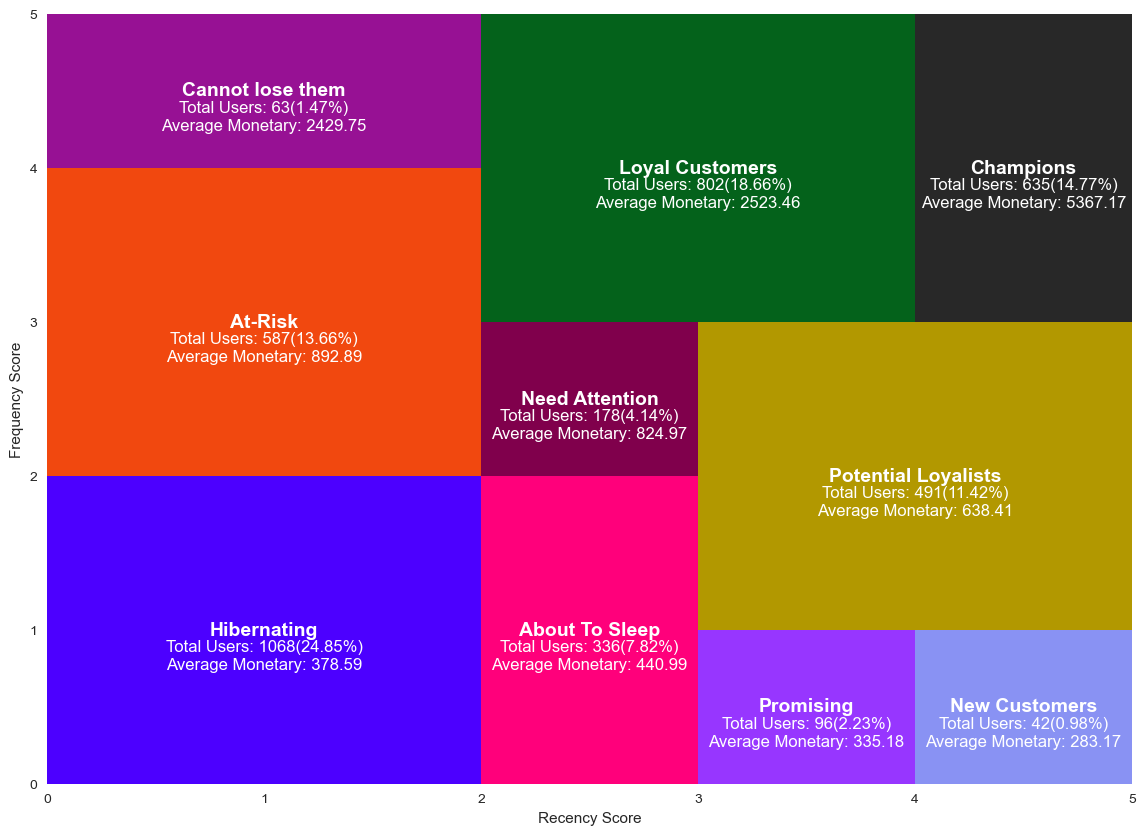

In [124]:
fig, ax = plt.subplots(figsize = (14, 10))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 14, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 12, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 12, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

**Visualizing RFM Segements:**

In [126]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "customer_id": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "Mean_Monetary", "customer_id": "Customer_Count"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("Mean_Monetary", ascending = False)

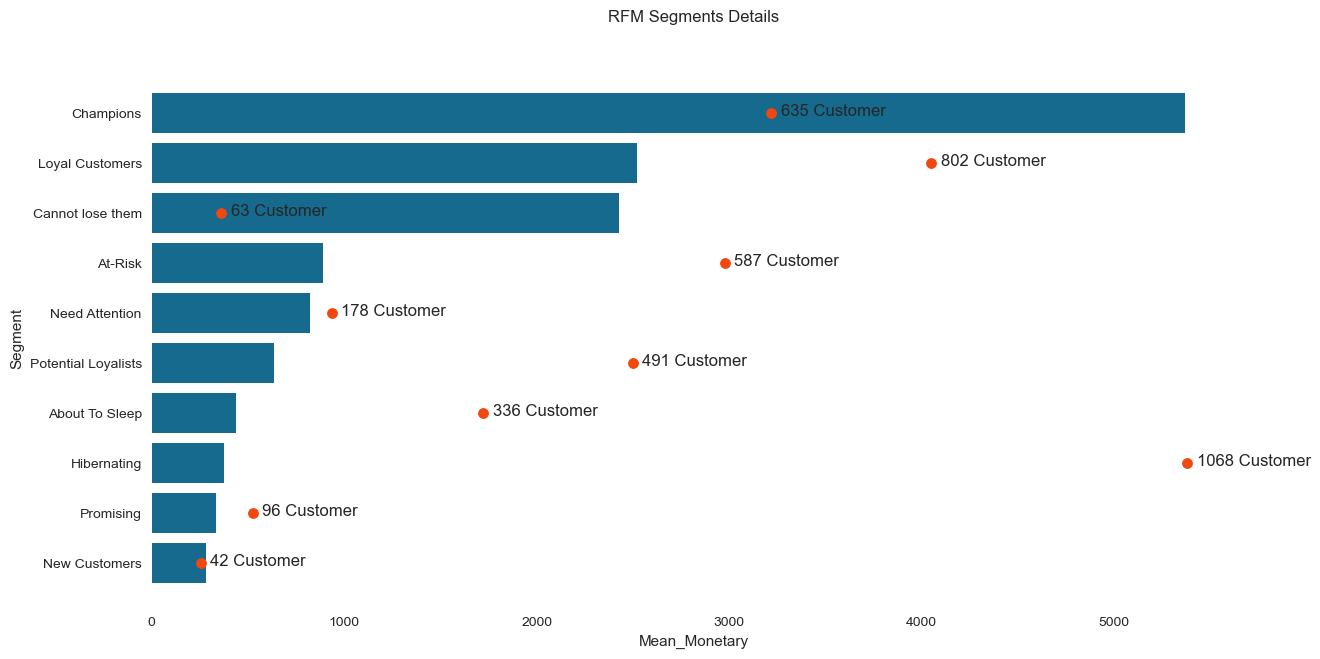

In [127]:
fig, ax = plt.subplots(figsize = (14, 7))

sns.barplot(x = rfm_monetary_size.Mean_Monetary, y = rfm_monetary_size.index, ax = ax)
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.Customer_Count, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")

ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.Customer_Count)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [128]:
rfm = rfm_table2.groupby("Segment").agg({"customer_id": "nunique", 
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"customer_id": "Segment Size"}, inplace = True)

In [129]:
cm = sns.light_palette("#A2A2A2", as_cmap=True)

# Applying the styles, using format() for precision control
rfm.T.style.background_gradient(cmap=cm, axis=1)\
    .format(precision=2)\
    .highlight_min(axis=1, color="#195190")\
    .highlight_max(axis=1, color="#D60000")

<Figure size 1400x500 with 0 Axes>

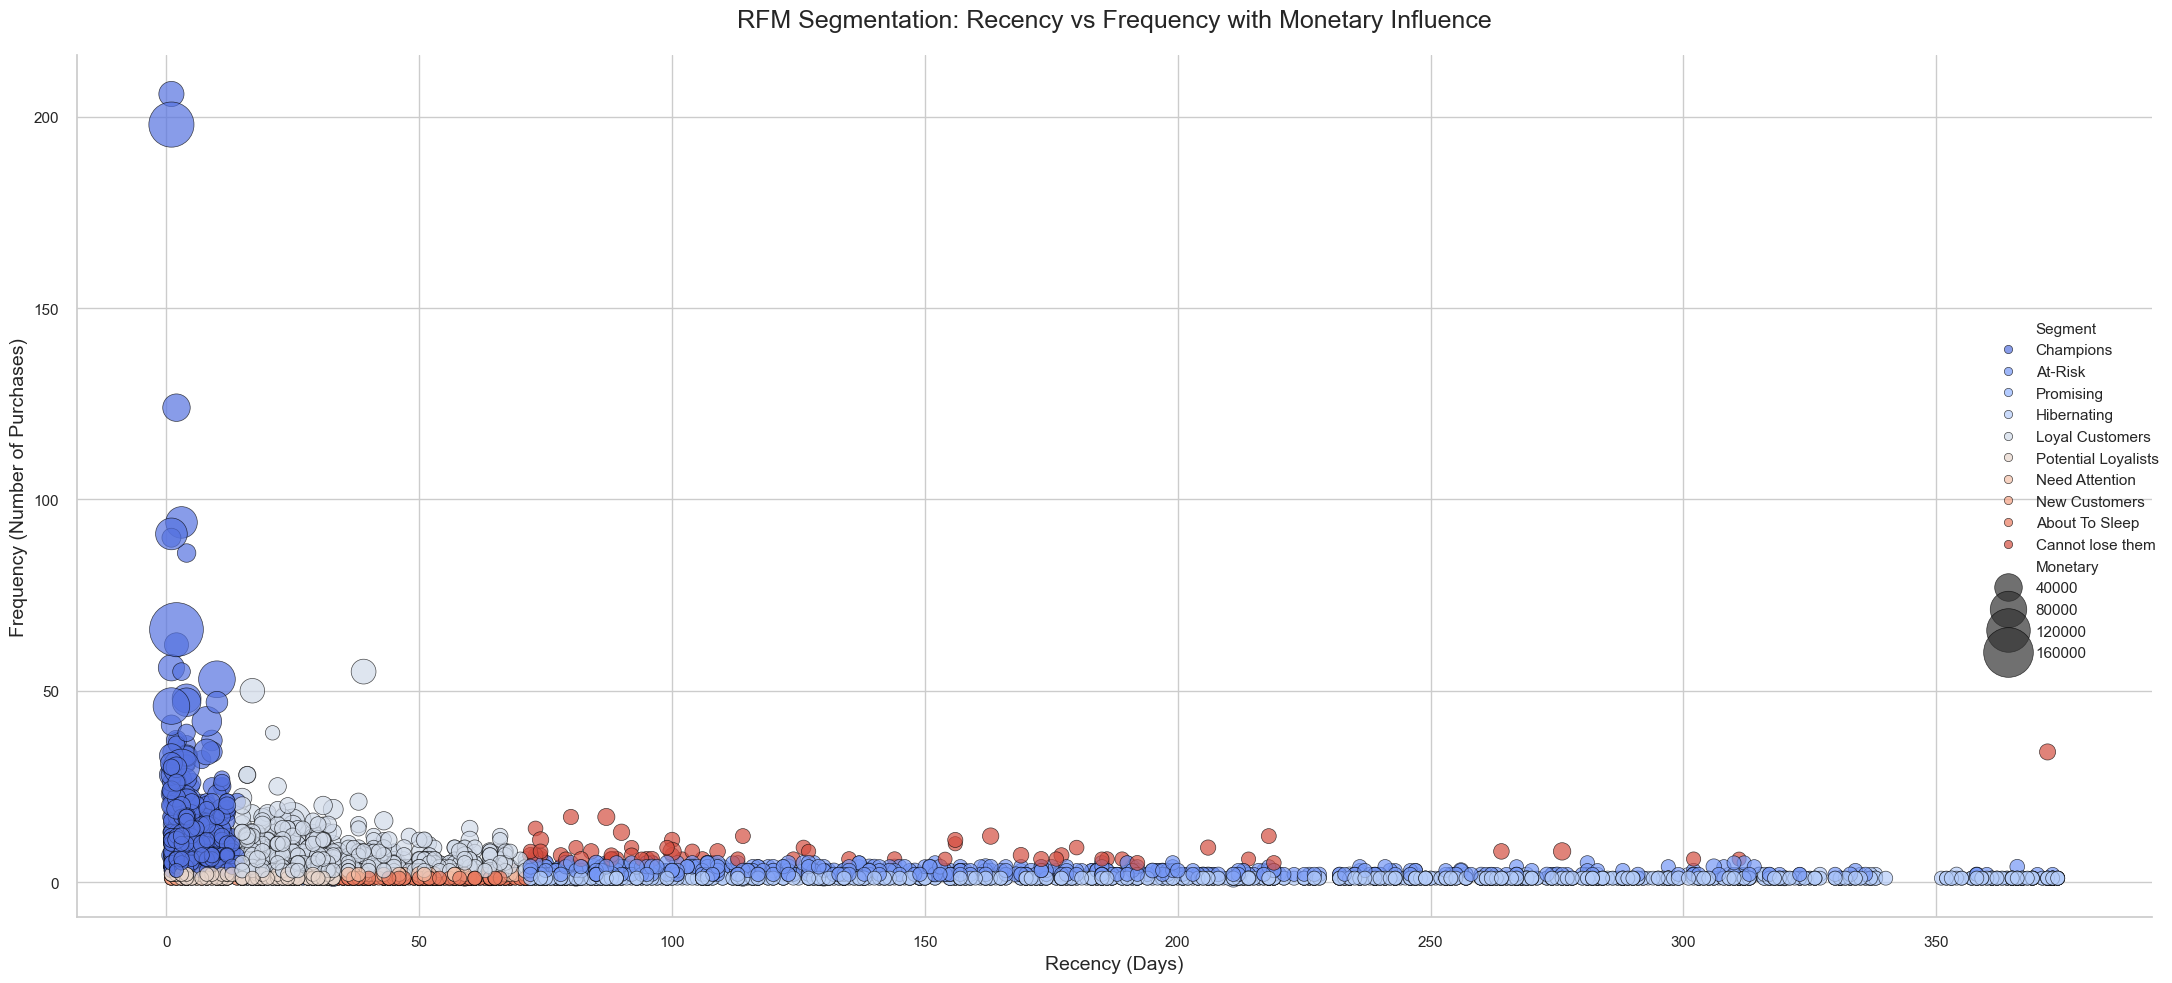

In [130]:
plt.figure(figsize=(14, 5)) 

sns.set(style="whitegrid") 

sns.relplot(
    x="Recency", y="Frequency", hue="Segment", size="Monetary",
    data=rfm_table2, palette="coolwarm",  
    height=10, aspect=2, sizes=(100, 1500), 
    alpha=0.7, edgecolor="black", linewidth=0.5 
)


plt.title("RFM Segmentation: Recency vs Frequency with Monetary Influence", fontsize=18, pad=20)
plt.xlabel("Recency (Days)", fontsize=14)
plt.ylabel("Frequency (Number of Purchases)", fontsize=14)

plt.tight_layout()
plt.show()

In [131]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

C:\Users\Maisam\AppData\Local\Temp\ipykernel_18296\1389664631.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y),


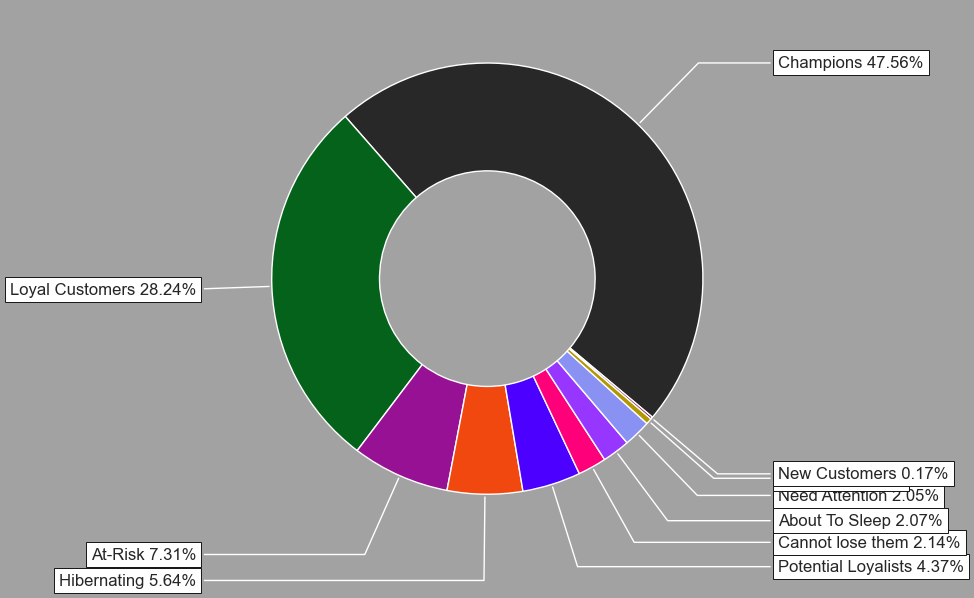

In [132]:
fig, ax = plt.subplots(figsize = (7, 7), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, normalize=False, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

47.5% of total revenue comes from "Champions" segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue.

In [134]:
# Make a copy of the original DataFrame to avoid SettingWithCopyWarning
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]].copy()

# Log transformation and scaling for each column
for col in ["Recency", "Frequency", "Monetary"]:
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])  # Apply log transformation
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[[col]])  # Use .loc[] is not needed here

# Melt the DataFrame for visualization
rfm_melted = pd.melt(rfm_clustering, 
                     id_vars="Segment", 
                     value_vars=["Recency", "Frequency", "Monetary"],
                     var_name="RFM", value_name="Value")

# Now proceed with your visualization or other operations

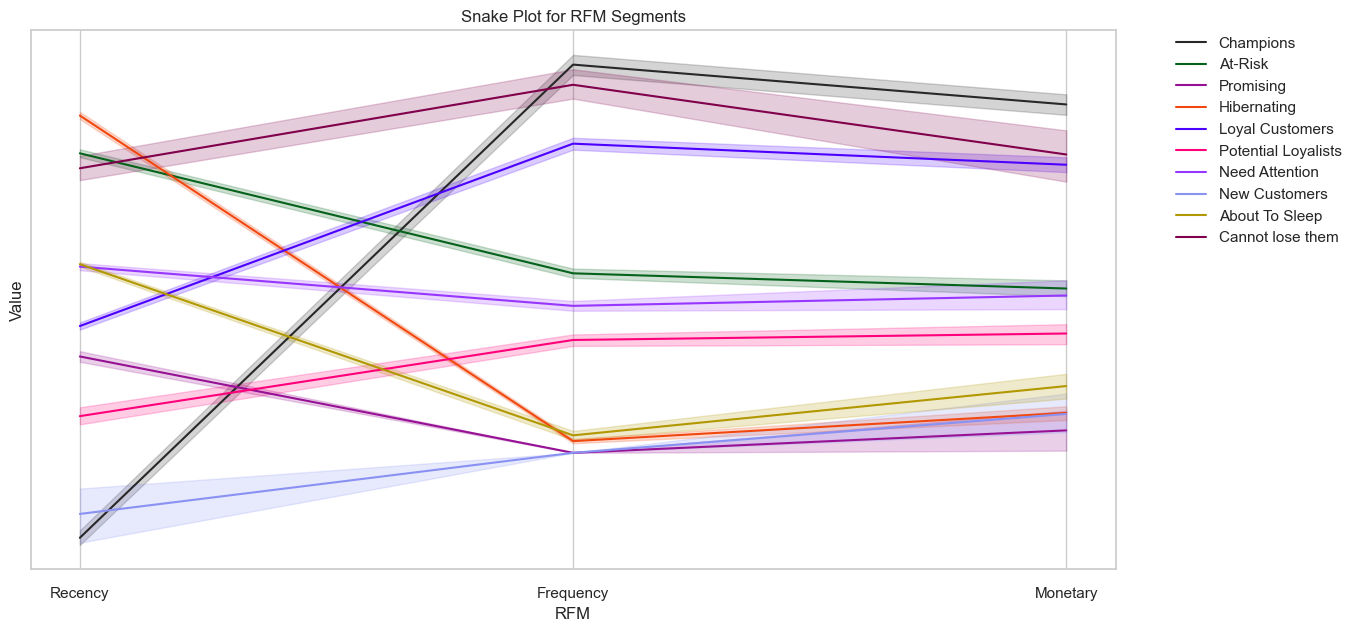

In [135]:
fig, ax = plt.subplots(figsize = (14, 7))

sns.lineplot(x = "RFM", y = "Value", hue = "Segment", data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()

**Customer Segmentation Using RFM Metrics:**

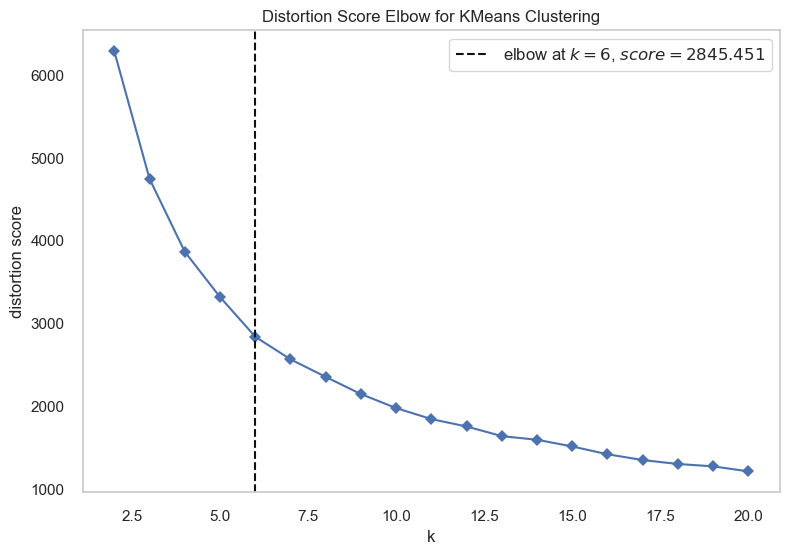

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [137]:
features = ["Recency", "Frequency", "Monetary"]

kmeans_ = KMeans(init = "k-means++", random_state = 42)

fig, ax = plt.subplots(figsize = (9, 6))
ax.grid(False)

visualizer = KElbowVisualizer(kmeans_, k = (2, 21), timings = False)

visualizer.fit(rfm_clustering[features]) 
visualizer.show()

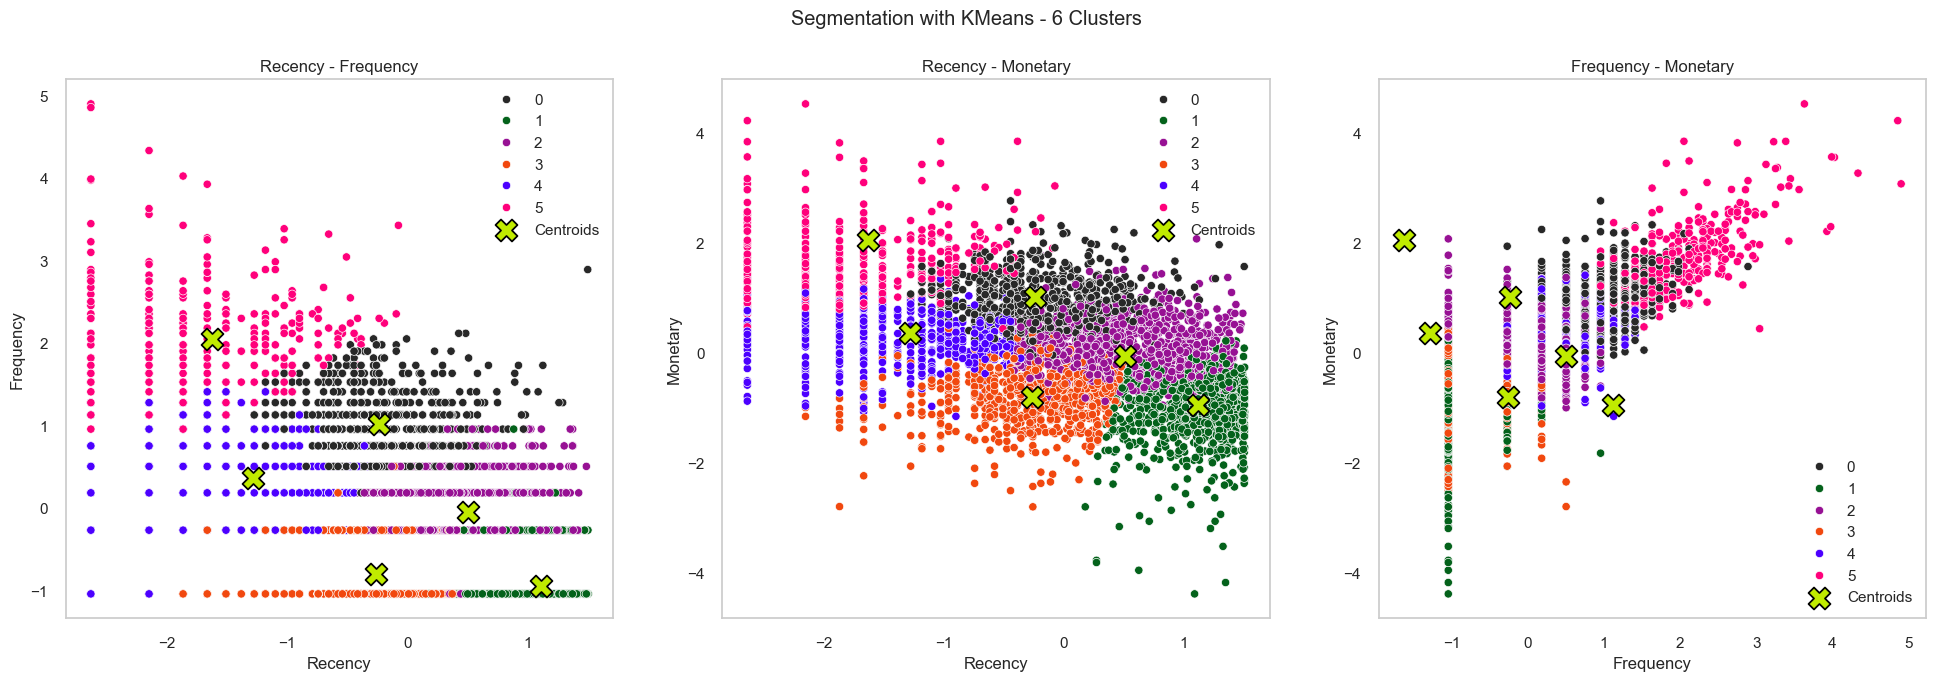

In [138]:
kmeans = KMeans(n_clusters = 6, random_state = 42) 
kmeans.fit(rfm_clustering[features])
cluster = kmeans.labels_

fig, axes = plt.subplots(1, 3, figsize = (24, 7))

for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue = cluster, 
                    palette = palette[: len(set(cluster))], ax = axes[i]).set_title(feature[0] + " - " + feature[1])

    sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1],
                    s = 250, color = '#C0EB00', label = 'Centroids', marker = "X", ax = axes[i], edgecolor = "black")

plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.grid(False)
    
plt.show()

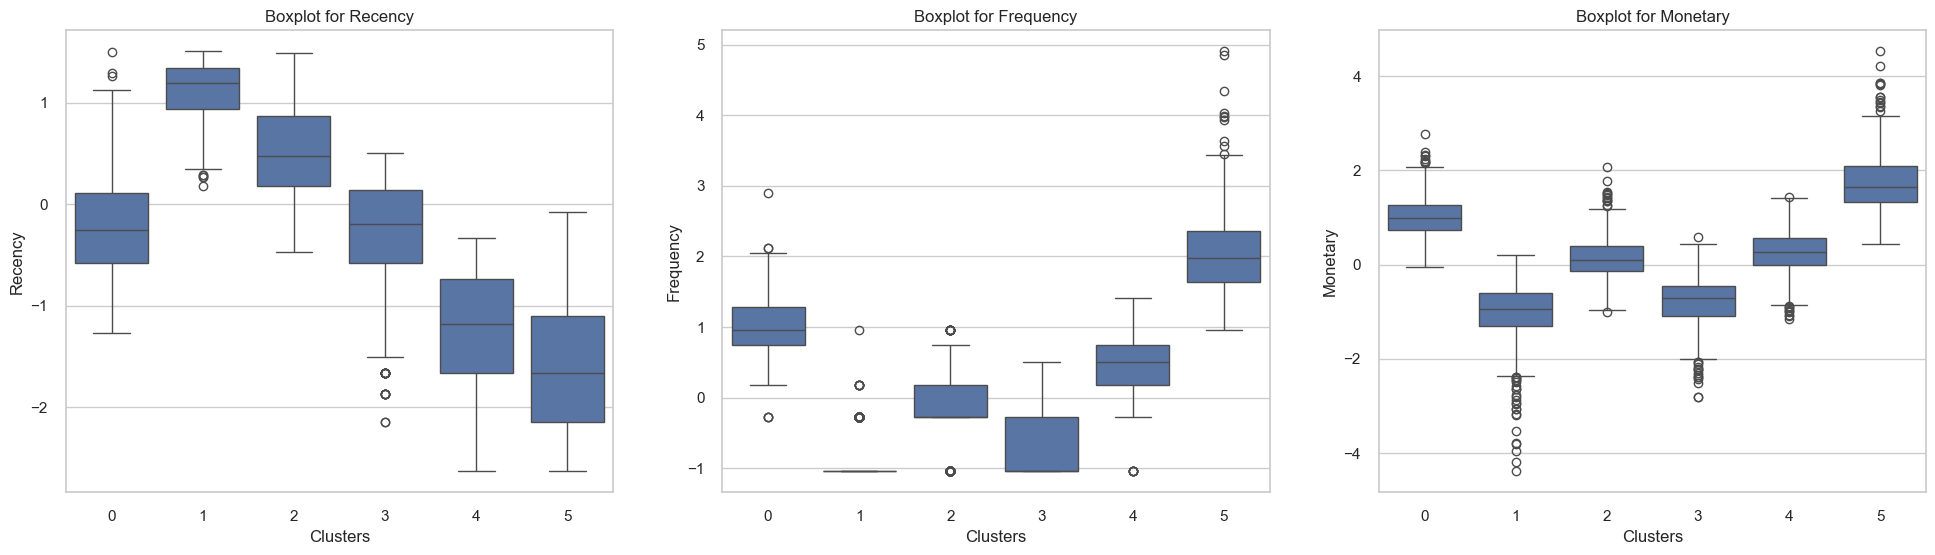

In [139]:
fig, axes = plt.subplots(1, 3, figsize = (24, 6))

for ax in axes:
    ax.set_xlabel("Clusters")
    
sns.boxplot(x = cluster, y = "Recency", data = rfm_clustering, ax = axes[0]).set_title("Boxplot for Recency")
sns.boxplot(x = cluster, y = "Frequency", data = rfm_clustering, ax = axes[1]).set_title("Boxplot for Frequency")
sns.boxplot(x = cluster, y = "Monetary", data = rfm_clustering, ax = axes[2]).set_title("Boxplot for Monetary")

plt.show()

In [140]:
plt.rcdefaults()

### 5. FORECASTING USING FB PROPHET:

In [142]:
df = pd.read_csv(r"C:\Users\Maisam\Downloads\Customer Lifetime Value - BG-NGB Modelling\online_retail_final.csv")

In [143]:
df.head()

invoice_no stock_code                          description  quantity  \
0      536365     85123A   white hanging heart t-light holder         6   
1      536365      71053                  white metal lantern         6   
2      536365     84406B       cream cupid hearts coat hanger         8   
3      536365     84029G  knitted union flag hot water bottle         6   
4      536365     84029E       red woolly hottie white heart.         6   

          invoice_date  unit_price  customer_id         country  total_price  
0  2010-12-01 08:26:00        2.55        17850  United Kingdom        15.30  
1  2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34  
2  2010-12-01 08:26:00        2.75        17850  United Kingdom        22.00  
3  2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34  
4  2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34

In [144]:
df.shape

(392735, 9)

For this analysis, we will only restrict the country to "UK".

In [146]:
df = df[df.country == "United Kingdom"]

In [147]:
df.shape

(351196, 9)

In [148]:
df.loc[:, "invoice_date"] = pd.to_datetime(df.loc[:, "invoice_date"])

print(f"First observation on data is {df.invoice_date.min()}")
print(f"Last observation on data is {df.invoice_date.max()}")

print(f"We have {(df.invoice_date.max() - df.invoice_date.min()).days} days.")

First observation on data is 2010-12-01 08:26:00
Last observation on data is 2011-12-09 12:49:00
We have 373 days.


In [149]:
df.set_index("invoice_date", inplace = True)
df.head()

C:\Users\Maisam\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


invoice_no stock_code  \
invoice_date                                 
2010-12-01 08:26:00      536365     85123A   
2010-12-01 08:26:00      536365      71053   
2010-12-01 08:26:00      536365     84406B   
2010-12-01 08:26:00      536365     84029G   
2010-12-01 08:26:00      536365     84029E   

                                             description  quantity  \
invoice_date                                                         
2010-12-01 08:26:00   white hanging heart t-light holder         6   
2010-12-01 08:26:00                  white metal lantern         6   
2010-12-01 08:26:00       cream cupid hearts coat hanger         8   
2010-12-01 08:26:00  knitted union flag hot water bottle         6   
2010-12-01 08:26:00       red woolly hottie white heart.         6   

                     unit_price  customer_id         country  total_price  
invoice_date                                                               
2010-12-01 08:26:00        2.55        17850  United Kingdom        15.30  
2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34  
2010-12-01 08:26:00        2.75        17850  United Kingdom        22.00  
2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34  
2010-12-01 08:26:00        3.39        17850  United Kingdom        20.34

**Understanding Trends - Weekly & Daily:**

In [151]:
sales_df = pd.DataFrame(df.groupby("invoice_date").total_price.sum())
sales_df = sales_df.iloc[:-1]
sales_df.head()

total_price
invoice_date                    
2010-12-01 08:26:00       139.12
2010-12-01 08:28:00        22.20
2010-12-01 08:34:00       348.78
2010-12-01 08:35:00        17.85
2010-12-01 09:00:00       204.00

In [152]:
weekly_sales = sales_df.resample("W").sum()
weekly_sales.head()

total_price
invoice_date             
2010-12-05      118082.07
2010-12-12      145153.96
2010-12-19      127871.19
2010-12-26       27718.88
2011-01-02           0.00

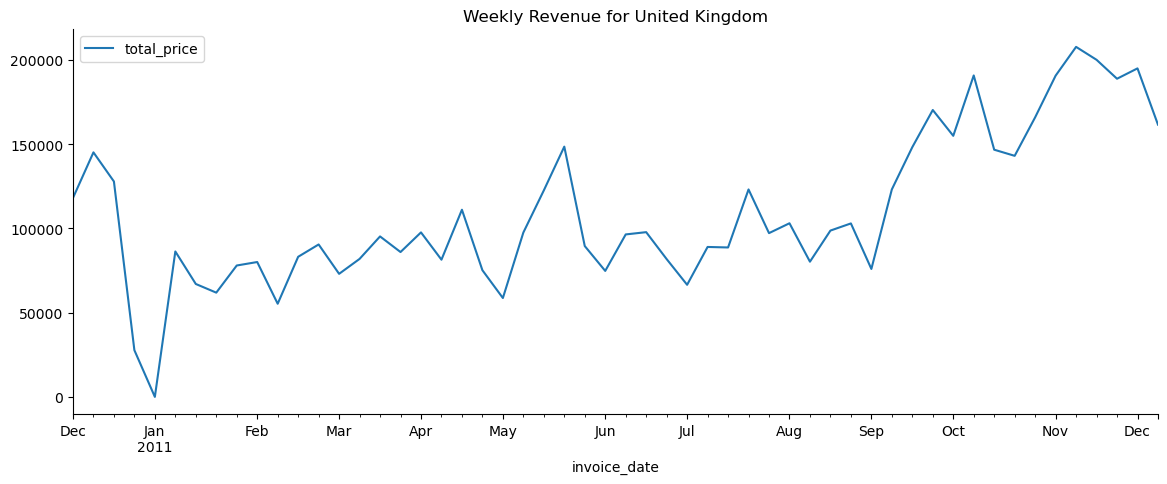

In [153]:
fig, ax = plt.subplots(figsize = (14, 5))

weekly_sales.plot(ax = ax).set_title("Weekly Revenue for United Kingdom")

ax.legend()
sns.despine()
plt.show()

In [154]:
daily_sales = pd.DataFrame(df.groupby("invoice_date").sum().resample("D").sum()["total_price"])
daily_sales.head()

total_price
invoice_date             
2010-12-01       34662.95
2010-12-02       40698.98
2010-12-03       17916.64
2010-12-04           0.00
2010-12-05       24803.50

We saw that there is a zero revenue week in earlier January.

In [156]:
daily_sales.loc["2010-12-23" : "2011-1-4"]

total_price
invoice_date             
2010-12-23        3963.97
2010-12-24           0.00
2010-12-25           0.00
2010-12-26           0.00
2010-12-27           0.00
2010-12-28           0.00
2010-12-29           0.00
2010-12-30           0.00
2010-12-31           0.00
2011-01-01           0.00
2011-01-02           0.00
2011-01-03           0.00
2011-01-04       11530.27

In [157]:
daily_sales.reset_index(inplace = True)
daily_sales["closed"] = np.where((daily_sales.total_price == 0), 1, 0)
daily_sales.set_index("invoice_date", inplace = True)

In [158]:
daily_sales["weekday"] = daily_sales.index.day_name()
daily_sales.head()

total_price  closed    weekday
invoice_date                                
2010-12-01       34662.95       0  Wednesday
2010-12-02       40698.98       0   Thursday
2010-12-03       17916.64       0     Friday
2010-12-04           0.00       1   Saturday
2010-12-05       24803.50       0     Sunday

In [159]:
daily_sales[daily_sales.total_price == 0].weekday.value_counts()

weekday
Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: count, dtype: int64

We don't have any records for 69 days. 53 of 69 are Saturdays. This retailer could be closed on Saturdays. Let's look at total revenues per weekday.

In [161]:
daily_sales.groupby("weekday").total_price.sum()

weekday
Friday        863095.82
Monday        951880.49
Saturday           0.00
Sunday        670059.45
Thursday     1267947.65
Tuesday      1049568.92
Wednesday    1100971.37
Name: total_price, dtype: float64

From the revenue per weekday, we can observe that this retailer is closed on Saturdays.

In [163]:
daily_sales_workdays = daily_sales[daily_sales.total_price > 0].copy()
daily_sales.drop("weekday", axis = 1, inplace = True)
daily_sales_workdays.drop("weekday", axis = 1, inplace = True)

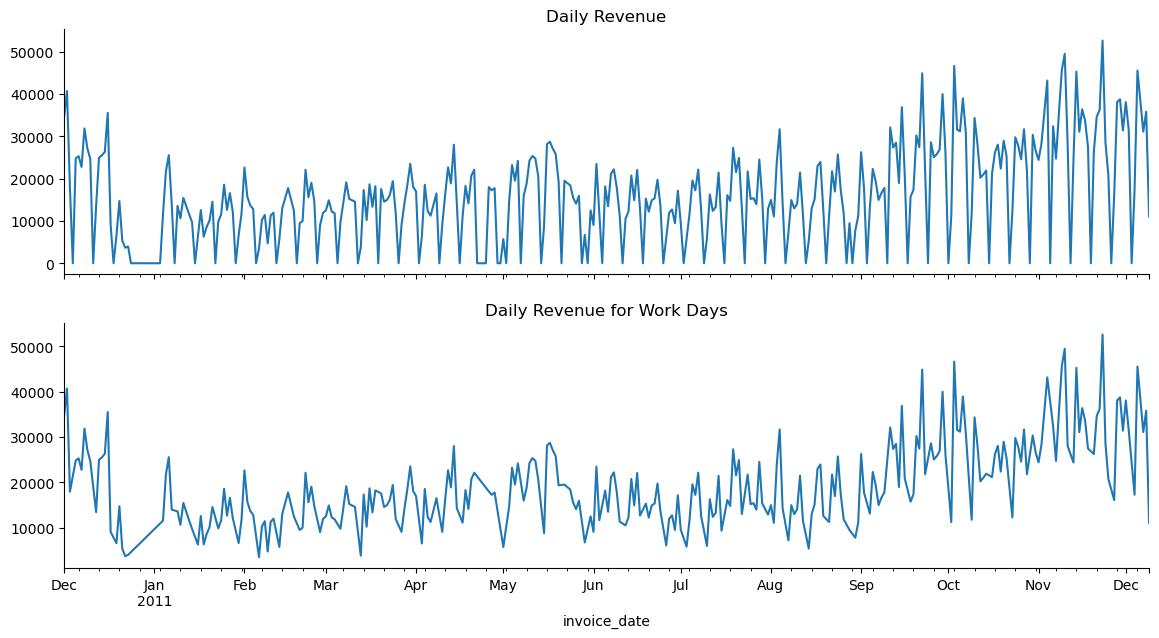

In [164]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 7))

daily_sales.total_price.plot(ax = axes[0]).set_title("Daily Revenue")
daily_sales_workdays.total_price.plot(ax = axes[1]).set_title("Daily Revenue for Work Days")

sns.despine()
plt.show()

**Stationarity in Time Series:**

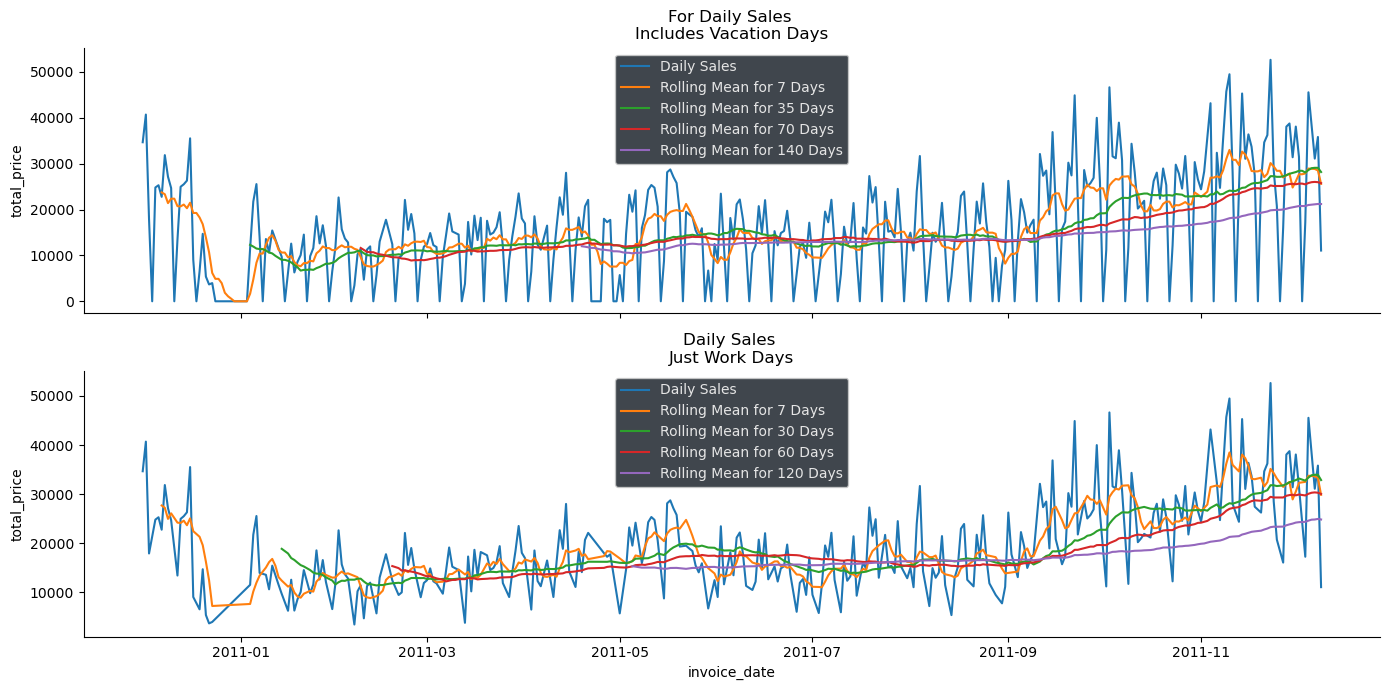

In [166]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 7))

 
sns.lineplot(x = daily_sales.index, y = daily_sales.total_price, 
             ax = axes[0], label = "Daily Sales").set_title("For Daily Sales \nIncludes Vacation Days")

sns.lineplot(x = daily_sales.index, y = daily_sales.total_price.rolling(7).mean(), 
             ax = axes[0], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.total_price.rolling(35).mean(), 
             ax = axes[0], label = "Rolling Mean for 35 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.total_price.rolling(70).mean(), 
             ax = axes[0], label = "Rolling Mean for 70 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.total_price.rolling(140).mean(), 
             ax = axes[0], label = "Rolling Mean for 140 Days")


sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price, 
             ax = axes[1], label = "Daily Sales").set_title("Daily Sales \nJust Work Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.rolling(6).mean(), 
             ax = axes[1], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.rolling(30).mean(),
             ax = axes[1], label = "Rolling Mean for 30 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean for 60 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.rolling(120).mean(), 
             ax = axes[1], label = "Rolling Mean for 120 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
    
sns.despine()
plt.tight_layout()
plt.show()

Let's check stationarity. Stationarity simply means that, our series has constant mean, variance on different times.

In above rolling mean plots, we saw that our mean values increase over time.

But, let's check it with Augmented Dickey Fuller test.

In [168]:
def check_adf(series, check = 0.05):
    
    adf = adfuller(series, autolag = "AIC")
    
    print(f"H0: {series.name} is non-stationary.")
    print(f"H1: {series.name} is stationary.\n")
    
    test_stat = adf[0]; print(f"ADF test statistic: {adf[0]}")
    pvalue = adf[1]; print(f"p-value: {adf[1]}")
    print(f"Number of lags: {adf[2]}")    
    print("\nCritical Values : \n")
    for key, item in adf[4].items(): print("\t", key, "\t", item)
    
    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary.")

In [169]:
print("Performing Augmented Dickey-Fuller test for Total Price \n")

check_adf(daily_sales.total_price)

print("\nPerforming Augmented Dickey-Fuller test for Total Price (for workdays)\n")

check_adf(daily_sales_workdays.total_price)

Performing Augmented Dickey-Fuller test for Total Price 

H0: total_price is non-stationary.
H1: total_price is stationary.

ADF test statistic: -2.371442041572222
p-value: 0.1499594163323652
Number of lags: 16

Critical Values : 

	 1% 	 -3.44880082033912
	 5% 	 -2.869670179576637
	 10% 	 -2.5711012838861036

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.

Performing Augmented Dickey-Fuller test for Total Price (for workdays)

H0: total_price is non-stationary.
H1: total_price is stationary.

ADF test statistic: -1.6611112579837568
p-value: 0.4512522148978475
Number of lags: 13

Critical Values : 

	 1% 	 -3.4530232710482367
	 5% 	 -2.871523926671883
	 10% 	 -2.5720897694878424

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.


For ADF test, this series is not stationary. To make it stationary, we have two main option.

- Take difference until it become stationary.
- Apply transformations: Log, square root, etc.

We can take difference with using .diff() method.
In this problem, our series has seasonal behaivor. Our revenue is increasing from saturday to thursday, then it decrease. For taking difference of seasonal series, we need set period in diff method.

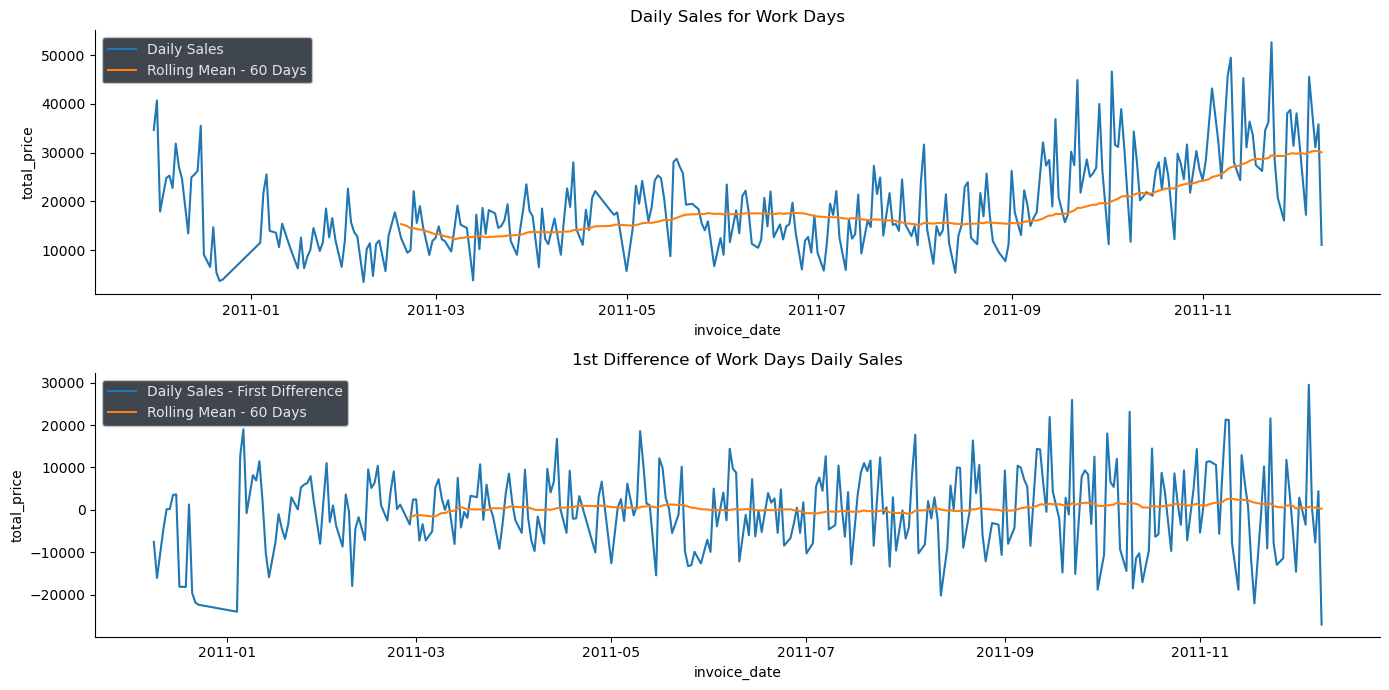

In [171]:
fig, axes = plt.subplots(2, 1, figsize = (14, 7))

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price, 
             ax = axes[0], label = "Daily Sales").set_title("Daily Sales for Work Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.rolling(60).mean(), 
             ax = axes[0], label = "Rolling Mean - 60 Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.diff(7), 
             ax = axes[1], label = "Daily Sales - First Difference").set_title("1st Difference of Work Days Daily Sales")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.total_price.diff(7).rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean - 60 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.tight_layout()
plt.show()

Nice, we have a constant mean over time. Let's look at ADF test results of 1st differenced series.

In [173]:
print("Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)")
check_adf(daily_sales["total_price"].diff(7).dropna())

print("\nPerforming Augmented Dickey-Fuller test for 1st Difference of Work Days Sales")
check_adf(daily_sales_workdays["total_price"].diff(6).dropna())

Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)
H0: total_price is non-stationary.
H1: total_price is stationary.

ADF test statistic: -7.2112411246750865
p-value: 2.2319745316403305e-10
Number of lags: 13

Critical Values : 

	 1% 	 -3.4490114443793214
	 5% 	 -2.8697627072503757
	 10% 	 -2.5711506161673716

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for 1st Difference of Work Days Sales
H0: total_price is non-stationary.
H1: total_price is stationary.

ADF test statistic: -6.345126133126613
p-value: 2.694674744994143e-08
Number of lags: 11

Critical Values : 

	 1% 	 -3.453342167806272
	 5% 	 -2.871663828287282
	 10% 	 -2.572164381381345

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.


**Seasonality & Decomposition:**

In [175]:
decompose = seasonal_decompose(daily_sales["total_price"], period = 7)

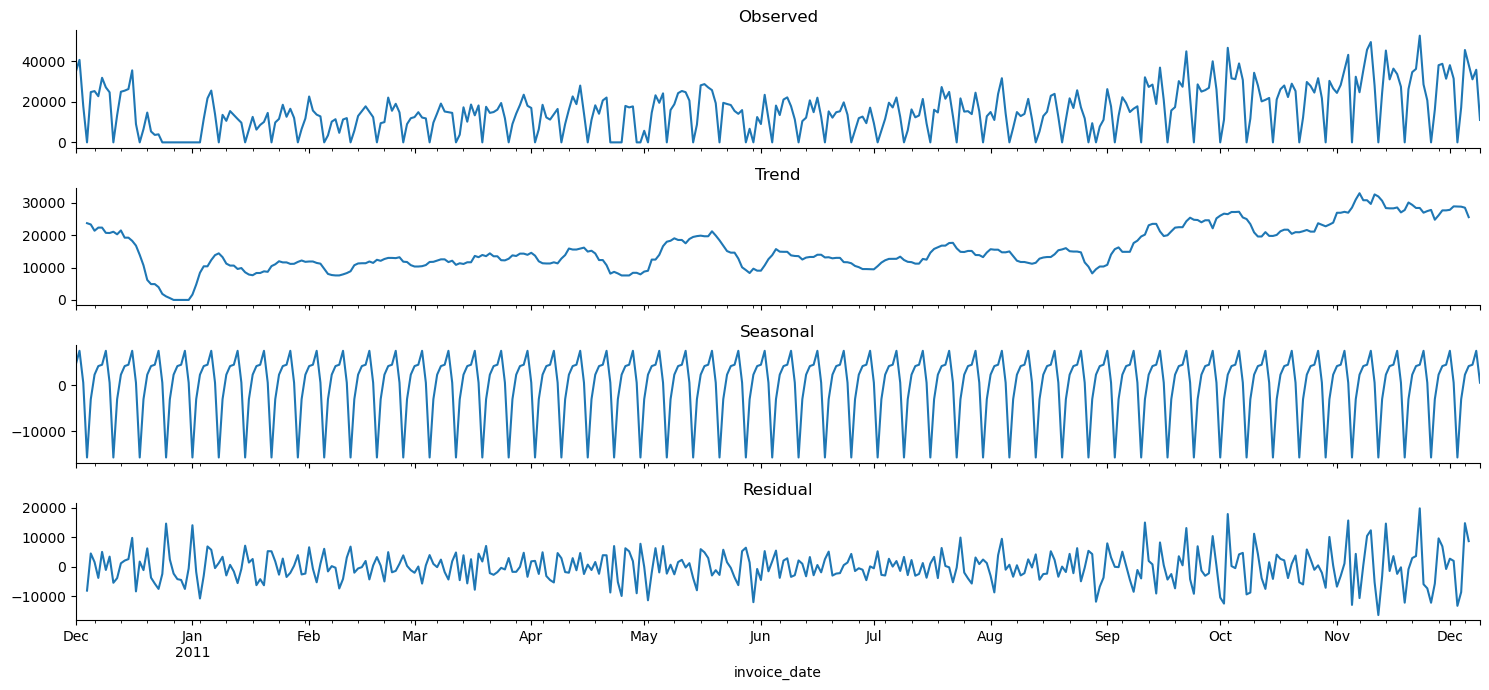

In [176]:
fig, axes = plt.subplots(4, 1, sharex = True, figsize = (15, 7))

decompose.observed.plot(ax = axes[0]).set_title("Observed")
decompose.trend.plot(ax = axes[1]).set_title("Trend")
decompose.seasonal.plot(ax = axes[2]).set_title("Seasonal")
decompose.resid.plot(ax = axes[3]).set_title("Residual")

sns.despine()
plt.tight_layout()
plt.show()

We can saw trend, seasonal component and residual. We know we have weekly seasonality. We need normal distributed residual.

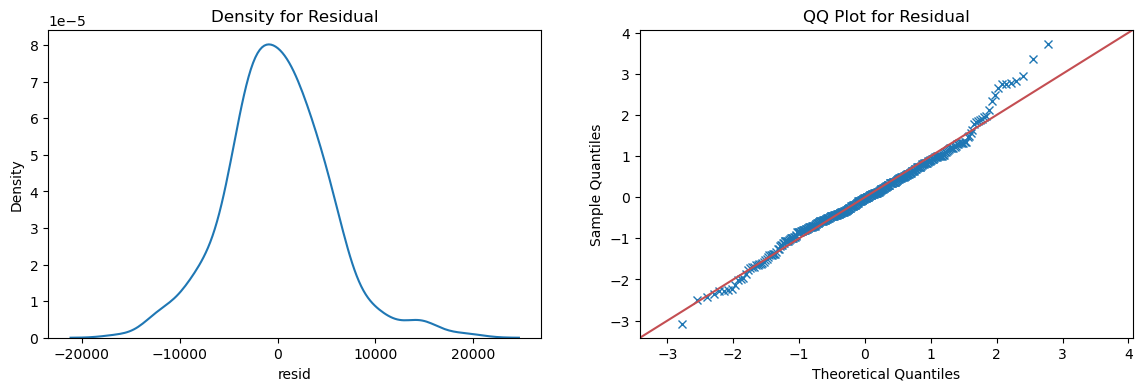

In [178]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    
sns.kdeplot(decompose.resid, ax = axes[0]).set_title("Density for Residual")

with warnings.catch_warnings(): 
    warnings.simplefilter("ignore")
    
    sm.qqplot(decompose.resid.dropna(), ax = axes[1], marker = "x", line = "45", fit = True)
    axes[1].set_title("QQ Plot for Residual")
    
plt.show()

As we can see kde plot and QQ plot, residual has normal distribution.

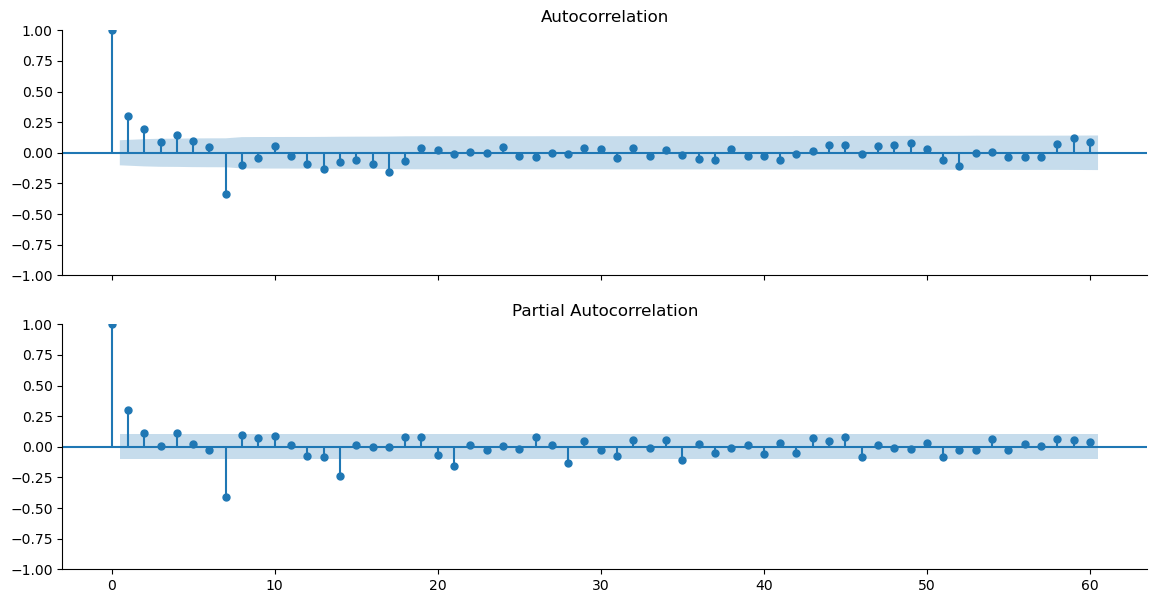

In [180]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 7))
    
plot_acf(daily_sales["total_price"].diff(7).dropna(), lags = 60, ax = axes[0])
plot_pacf(daily_sales["total_price"].diff(7).dropna(), lags = 60, ax = axes[1])

sns.despine()
plt.show()

**Modelling:**

We will use daily sales data for model training. We have 0 values on saturdays, it is fixed. We can get rid of these records with subsetting the data, just like stock prices.

For training set, I just get first 85% records of all days, and remaining part is validation set.

First of all, I want to say again, my main goal is getting more detailed project about this dataset. As we talk theoretical part, I think this dataset is not fully convenient for forecasting. We have one year data and after then major peak, we don't have a lot observations to predicting the behaivor of data.

This part would be a simple introduction of Facebook's Prophet, and I probably prepare more detailed notebooks about these concepts.

In [311]:
daily_data = daily_sales[["total_price"]].dropna().reset_index()

daily_data.columns = ["ds", "y"]

train_size = int(0.85 * len(daily_data))

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t{len(train)} \nValidation Days:\t {len(val)}")

Training Days:		317 
Validation Days:	 57


For this problem our metrics are R2, mean squared error and correlation. Actually, I don't like to use infinite intervaled metrics like MSE, but I just add it for variety.

In [320]:
def scores(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")

**Simple Model:**

In [323]:
model = Prophet()

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

13:58:19 - cmdstanpy - INFO - Chain [1] start processing
13:58:19 - cmdstanpy - INFO - Chain [1] done processing


In [325]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.5363842272076815
MSE: 42909056.78291415
Correlation: 0.7325443052610539

For Validation set: 

R2: 0.4846090968599477
MSE: 93016518.01181984
Correlation: 0.8403400201548727


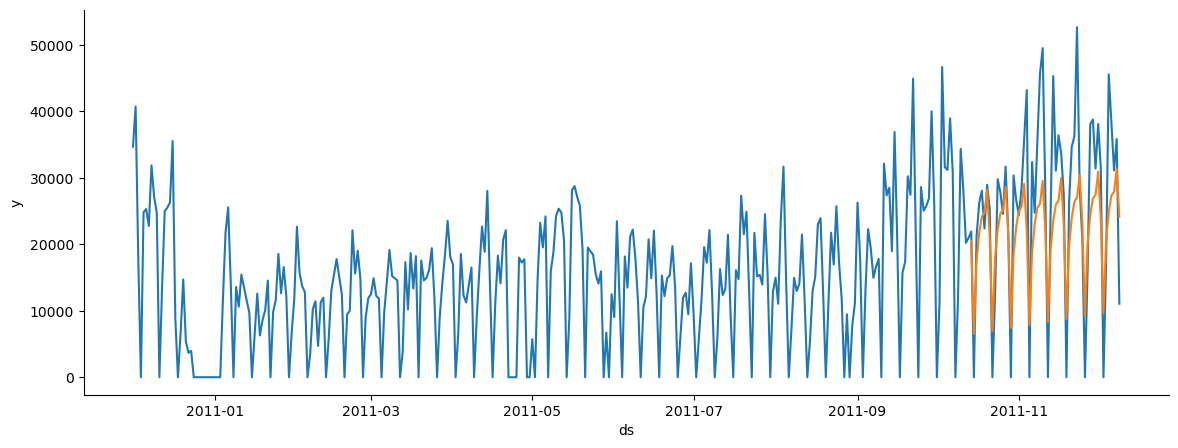

In [327]:
fig, ax = plt.subplots(figsize = (14, 5))

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax)
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax)

sns.despine()
plt.show()

**Tweaking Prophet's Parameters For Better Fit:**

In [338]:
black_friday = pd.DataFrame(
    {
        "holiday": "black friday",
        "ds": pd.to_datetime(["2011-11-24", "2012-11-23", "2013-11-22"]),
        "lower_window": 0,
        "upper_window": 1
    }
)

In saturdays, we don't have any sale record. we will simply add "is_saturday" column as an extra regressor.

In [341]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == "Saturday"

daily_data["is_saturday"] = daily_data["ds"].apply(is_saturday)

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

Prophet gives lots of options in model building step.

- holidays: You can use this for adding special days to model.
- seasonality: If the data has seasonality, you can set daily_seasonality, weekly_seasonality, and yearly_seasonality parameters to True.
- _prior_scale: This parameter controls the flexibility of components' affects.

In this model, we just set them with simple numbers. You can turn them with [0.01-10] range.

Also you can use add_country_holidays(country) method for adding all holidays for a country.

In [344]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

14:00:56 - cmdstanpy - INFO - Chain [1] start processing
14:00:56 - cmdstanpy - INFO - Chain [1] done processing


In [346]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.6975700268018992
MSE: 27990818.376720086
Correlation: 0.8353167199134925

For Validation set: 

R2: 0.4713747465836443
MSE: 95405021.90925086
Correlation: 0.8133429451019338


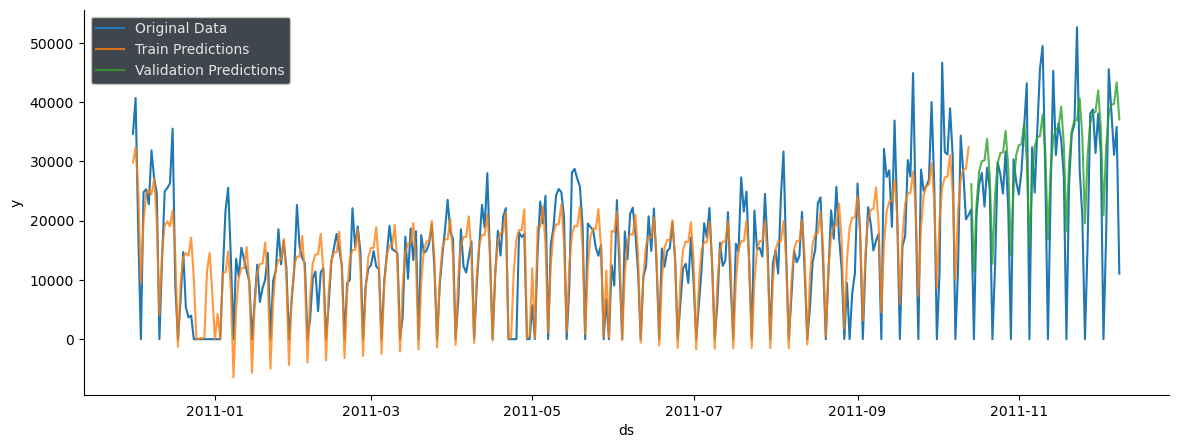

In [353]:
fig, ax = plt.subplots(figsize = (14, 5))

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

We have a problem, we get negative valued forecasts. Actually, using "floor" and "cap" didn't work for us. 

http://facebook.github.io/prophet/docs/saturating_forecasts.html#saturating-minimum

To get rid of this, we will manually set them zero.


In [359]:
train_pred["yhat"] = np.where((train_pred.is_saturday == 0), train_pred.yhat, 0)
val_pred["yhat"] = np.where((val_pred.is_saturday == 0), val_pred.yhat, 0)

print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.7182861103541638
MSE: 26073481.52661704
Correlation: 0.8484320879387891

For Validation set: 

R2: 0.681466442015255
MSE: 57488175.00103555
Correlation: 0.848647200147765


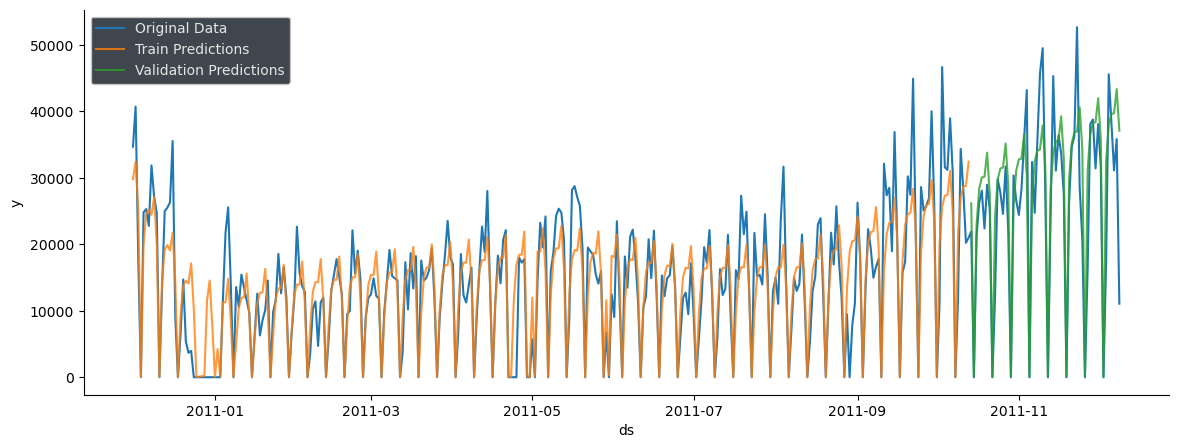

In [361]:
fig, ax = plt.subplots(figsize = (14, 5))

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

Our model can not capture sudden peaks well. Actually, we have to investigate the reasons underlying this peaks. Is it yearly seasonal, or not? We can not detect it since we have only one year data.

**Forecasting Future:**

Now, we will build a new model for forecasting next year. We just add yearly seasonality to last model that we used.

In [370]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    yearly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(daily_data)

14:03:51 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing


In [372]:
future = model.make_future_dataframe(periods = 365)

future["is_saturday"] = future["ds"].apply(is_saturday)
future.tail()

ds  is_saturday
734 2012-12-04        False
735 2012-12-05        False
736 2012-12-06        False
737 2012-12-07        False
738 2012-12-08         True

In [376]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

ds          yhat    yhat_lower    yhat_upper
734 2012-12-04  33088.647257  25161.476785  40502.930298
735 2012-12-05  32654.056645  25525.500912  39986.985430
736 2012-12-06  35184.814473  28178.005855  42359.304137
737 2012-12-07  27396.182169  19623.771986  34459.639392
738 2012-12-08   9535.767118   2506.639850  16947.126488

C:\Users\Maisam\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Maisam\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


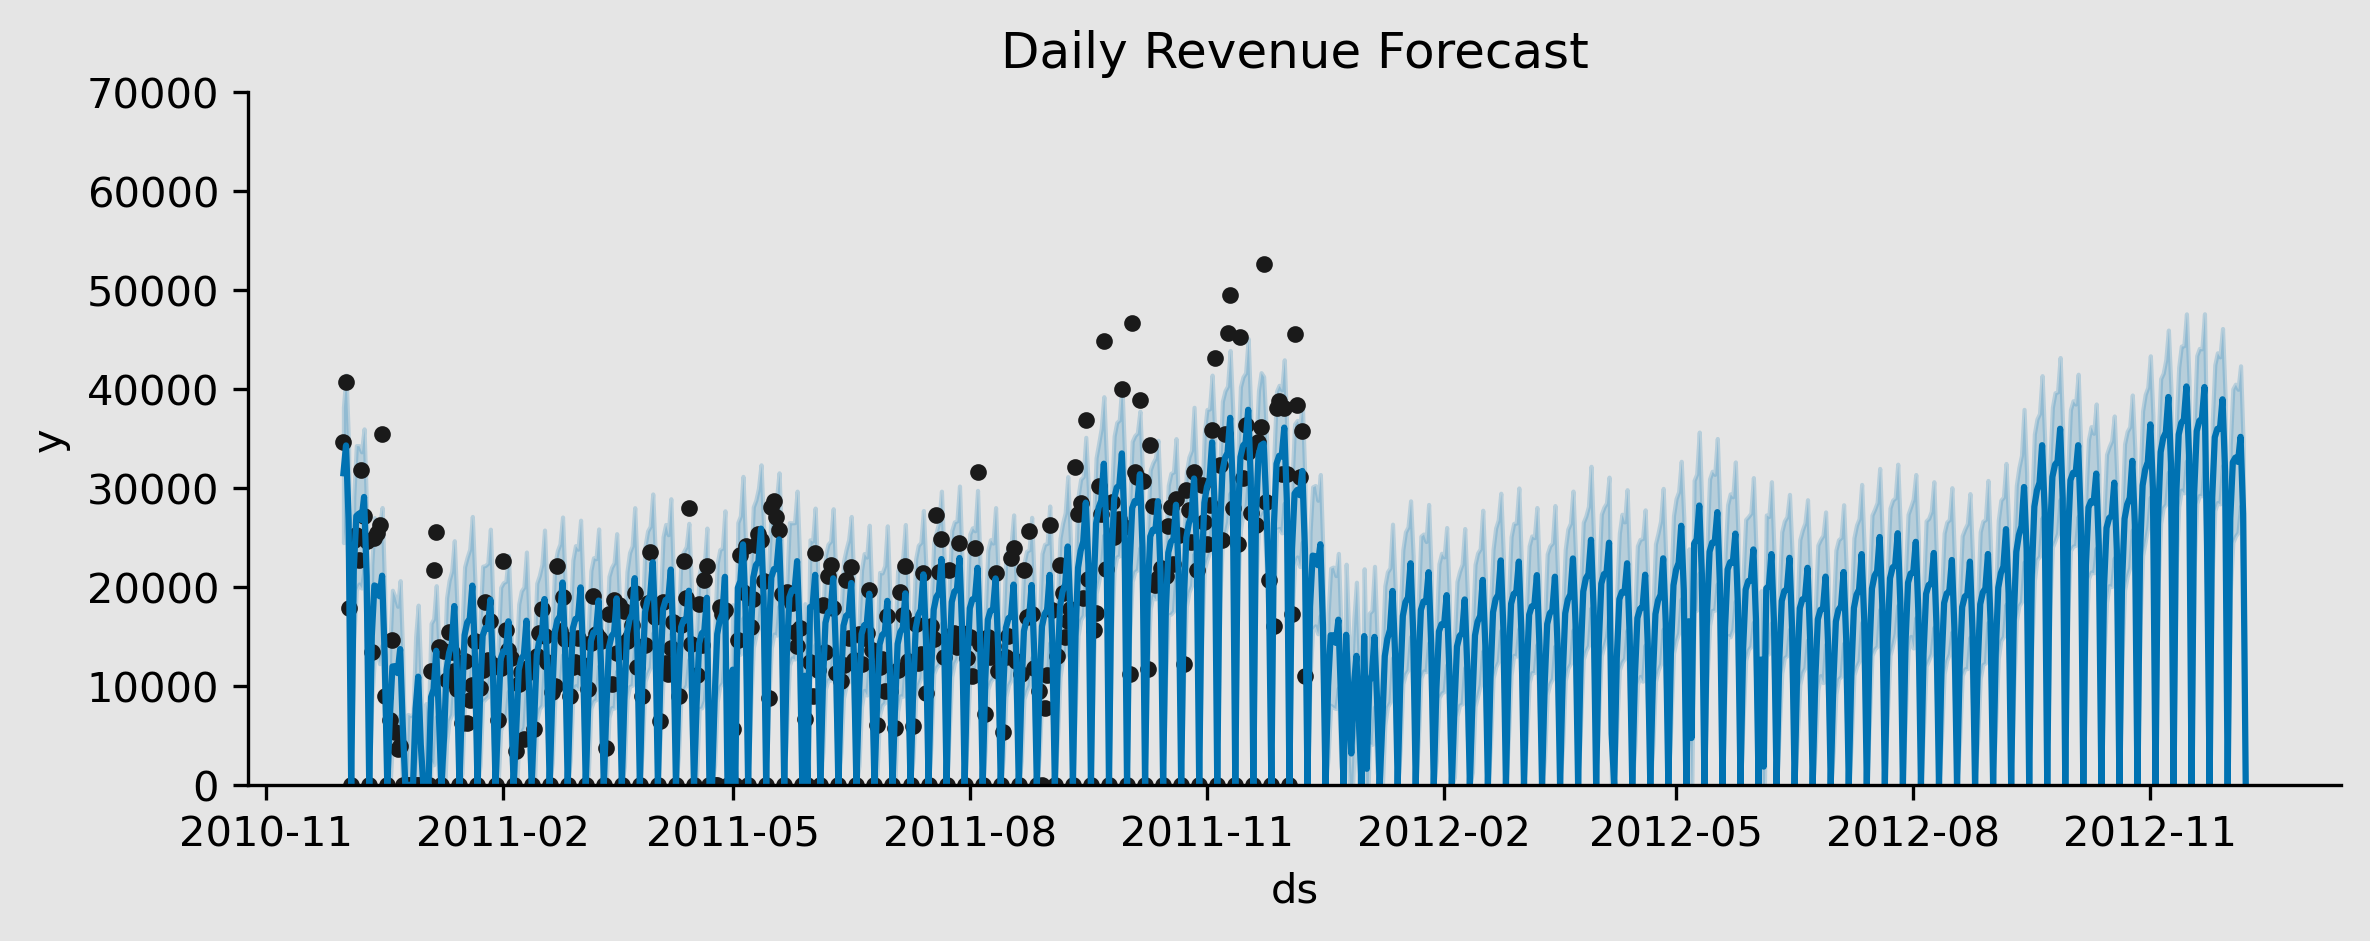

In [381]:
forecast["yhat"] = np.where((forecast.is_saturday == 0), forecast.yhat, 0)
forecast["yhat_lower"] = np.where((forecast.is_saturday == 0), forecast.yhat_lower, 0)
forecast["yhat_upper"] = np.where((forecast.is_saturday == 0), forecast.yhat_upper, 0)

fig, ax = plt.subplots(figsize = (9, 3), facecolor = "#e5e5e5", dpi = 300)

model.plot(forecast, ax = ax)

ax.set_title("Daily Revenue Forecast")
ax.grid(False)
ax.set_facecolor("#e5e5e5")
ax.set_ylim(0, 70000)

sns.despine()
plt.show()

Here is the results of this year's predictions and next year's forecast. Black dots represent actual revenue, and blue lines represent forecasts.

In the last months of the year, our predictions on the border of upper confidence interval, or sometimes outside of it.

If we look at next year's forecast, we can see minor peaks in the middle of the year, and also we have positive trend late of the year.